<a href="https://colab.research.google.com/github/2Sam392/DRY-AMD-Dissertation/blob/main/Dry_AMD_Classification_(2)_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification (Normal vs Dry AMD)**

## **1. Install MONAI**

In [ ]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.4 MB/s eta 0:00:00


## **2. Importing Libraries**

In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.dev2431
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 951a77d7a7737a3108afa94623a50b87d21eb4a7
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.0
Nibabel version: 5.0.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 9.4.0
Tensorboard version: 2.17.0
gdown version: 4.7.3
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.1.4
einops version: 0.8.0
transformers version: 4.42.4
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html

## **3. Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **4.  Read Images from Dataset**

In [ ]:
data_dir = '/content/drive/MyDrive/Dry AMD/Fundus Images'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x)
                for x in os.listdir(os.path.join(data_dir, class_name))]
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 2619
Image dimensions: 512 x 512
Label names: ['Dry AMD', 'Normal']
Label counts: [1273, 1346]


## **5.  EDA(Exploratory Data Analysis)**




### 5.1 Visualise some randomly picked examples from the dataset

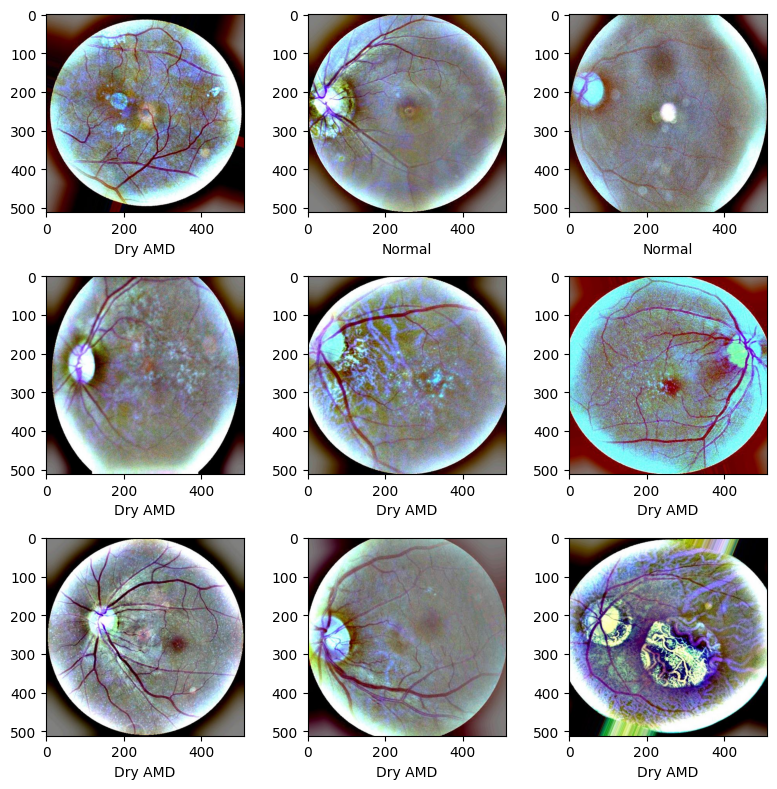

In [ ]:
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

### 5.2 Visualize first 4 Images of Each class

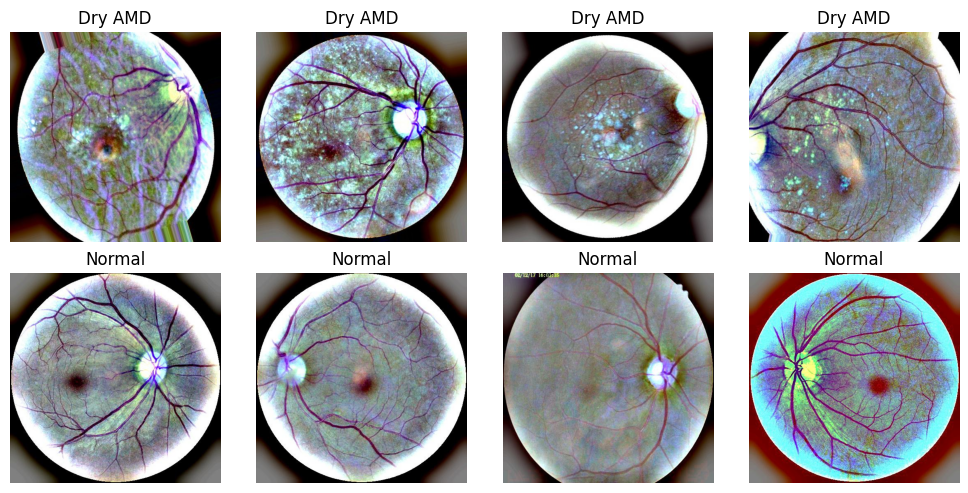

In [ ]:
# Number of classes
num_classes = 2

# Number of images per class to display
num_images_per_class = 4

fig, axes = plt.subplots(2, num_images_per_class, figsize=(10, 5))

# Loop over each class
for class_index in range(num_classes):
    # Find all indices of the current class
    class_indices = [i for i, label in enumerate(image_label_list) if label == class_index]

    # Randomly select images from the current class
    selected_indices = np.random.choice(class_indices, num_images_per_class, replace=False)

    # Loop over the selected images
    for j, image_index in enumerate(selected_indices):
        im = Image.open(image_file_list[image_index])
        arr = np.array(im)

        ax = axes[class_index, j]
        ax.set_title(class_names[class_index])
        ax.imshow(arr, cmap='gray', vmin=0, vmax=255)
        ax.axis('off')  # Hide axis

plt.tight_layout()
plt.show()

### 5.3 Visualize Instance Distributin of each class

{'Normal': 1346, 'Dry AMD': 1273}


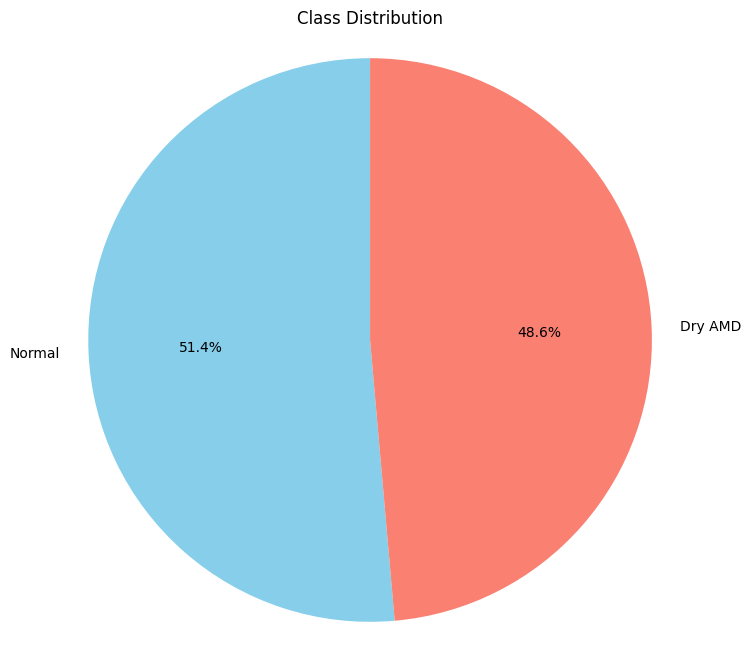

In [ ]:
# List of class names (subdirectory names)
class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Count the number of files in each class directory
class_counts = []
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts.append(file_count)

# Print the class counts
print(dict(zip(class_names, class_counts)))

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


## **6.  Prepare training, validation and test data lists**

In [ ]:
import numpy as np

# Set seed for reproducibility
np.random.seed(32)

# Assuming image_file_list and image_label_list are provided
num_total = len(image_file_list)
valid_frac, test_frac = 0.19, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =", len(trainX), "Validation count =", len(valX), "Test count =", len(testX))


Training count = 1836 Validation count = 512 Test count = 271


## **7. Define MONAI transforms, Dataset and Dataloader to pre-process data**

In [ ]:

from torchvision.transforms import Compose, Grayscale, ToTensor
from monai.transforms import Activations, AsDiscrete, LoadImage, EnsureChannelFirst, ScaleIntensity, RandRotate, RandFlip, RandZoom, ToTensor as MONAIToTensor
from monai.networks.nets import DenseNet121
# Define training and validation transforms with grayscale conversion
train_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    Grayscale(num_output_channels=1),  # Convert to grayscale
    MONAIToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    Grayscale(num_output_channels=1),  # Convert to grayscale
    MONAIToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class)

**Custom Dataset class for visualization**

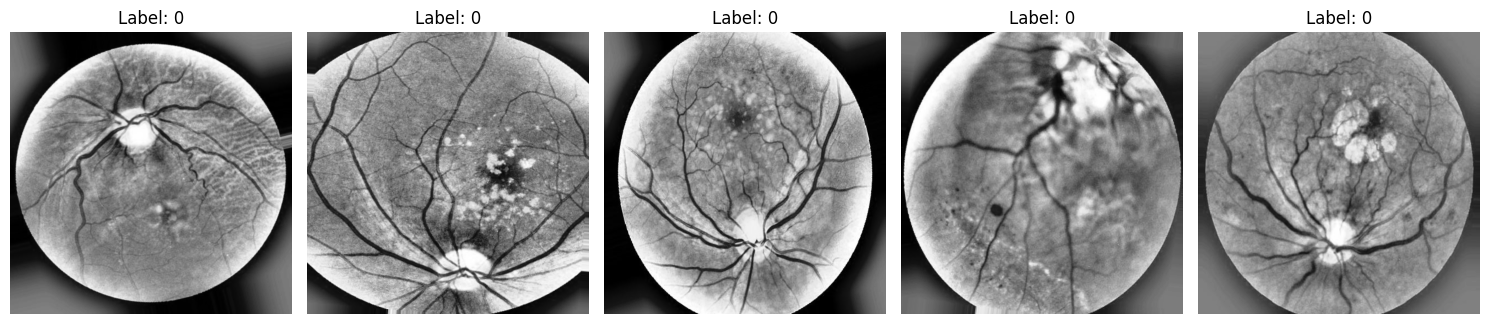

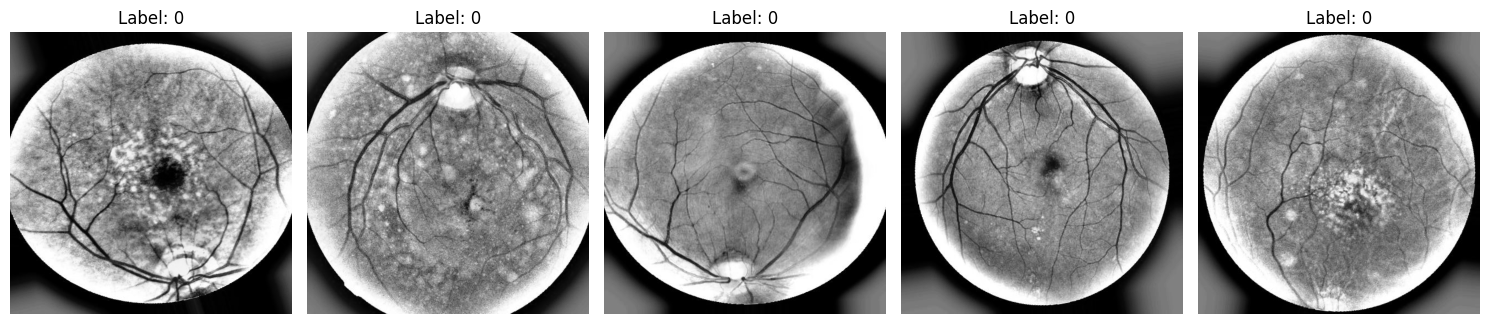

In [ ]:
class fundus_dataset(Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image = self.transforms(self.image_files[index])
        label = self.labels[index]
        return image, label

    def visualize(self, num_images=5):
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i in range(num_images):
            image, label = self.__getitem__(i)
            image_np = np.squeeze(image.cpu().numpy())  # Convert tensor to numpy array
            axes[i].imshow(image_np, cmap='gray', vmin=0, vmax=1)
            axes[i].set_title(f'Label: {label}')
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()

# Instantiate datasets
train_ds = fundus_dataset(trainX, trainY, train_transforms)
val_ds = fundus_dataset(valX, valY, val_transforms)
test_ds = fundus_dataset(testX, testY, val_transforms)

# Visualize some images from the training set after transformations
train_ds.visualize(num_images=5)
val_ds.visualize(num_images=5)

## **8. Define a custom dataset class for the fundus images**

In [ ]:
class fundus_dataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = fundus_dataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)

val_ds = fundus_dataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=2)

test_ds = fundus_dataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=16, num_workers=2)

## **9.  Models Implementation**

### **9.1  DenseNet121**

In [ ]:
device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
val_interval = 1

9.1.1 Training DenseNet

In [ ]:
from torch.optim.lr_scheduler import StepLR
# Initialize the learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Early stopping parameters
early_stopping_patience = 10
early_stopping_counter = 0

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize variables
dense_best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
epoch_acc_values = []
val_loss_values = []
auc_metric = ROCAUCMetric()
metric_values = []
val_acc_values = []
val_interval = 1  # validation interval (every epoch)
epoch_num = 10  # total number of epochs
best_auc = -1
best_auc_epoch = -1
best_precision = -1
best_recall = -1
best_f1 = -1
best_acc = -1

# Path to save the model on Google Drive
save_path = '/content/drive/MyDrive/Dry AMD/Model metrics/best_dense_metric_model.pth'

# Training loop with checkpointing
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    # Training phase
    model.train()
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        epoch_correct += (predicted == labels).sum().item()
        epoch_total += labels.size(0)

        print(f"{step}/{len(train_loader)}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_accuracy = epoch_correct / epoch_total
    epoch_loss_values.append(epoch_loss)
    epoch_acc_values.append(epoch_accuracy)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}, average accuracy: {epoch_accuracy:.4f}")

    # Step the scheduler
    scheduler.step()

    # Validation phase
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        val_steps = 0
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                outputs = model(val_images)
                val_loss += loss_function(outputs, val_labels).item()
                val_steps += 1
                y_pred = torch.cat([y_pred, outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            val_loss /= val_steps
            val_loss_values.append(val_loss)

            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            metric_values.append(auc_result)

            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            val_acc_values.append(acc_metric)

            # Compute precision, recall, and F1-score
            y_true_cpu = y.cpu().numpy()
            y_pred_cpu = y_pred.argmax(dim=1).cpu().numpy()
            precision = precision_score(y_true_cpu, y_pred_cpu, average='weighted')
            recall = recall_score(y_true_cpu, y_pred_cpu, average='weighted')
            f1 = f1_score(y_true_cpu, y_pred_cpu, average='weighted')

            # Update best metrics
            if auc_result > best_auc:
                best_auc = auc_result
                best_auc_epoch = epoch + 1
                early_stopping_counter = 0  # Reset early stopping counter if AUC improves

            if precision > best_precision:
                best_precision = precision
            if recall > best_recall:
                best_recall = recall
            if f1 > best_f1:
                best_f1 = f1
            if acc_metric > dense_best_metric:
                dense_best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'dense_best_metric': dense_best_metric,
                    'best_metric_epoch': best_metric_epoch,
                    'best_auc': best_auc,
                    'best_auc_epoch': best_auc_epoch,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'best_f1': best_f1,
                }, save_path)
                print('saved new best metric model')

            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} current precision: {precision:.4f}"
                  f" current recall: {recall:.4f} current F1-score: {f1:.4f} best AUC: {best_auc:.4f}"
                  f" at epoch: {best_auc_epoch} best accuracy: {dense_best_metric:.4f}"
                  f" at epoch: {best_metric_epoch} best precision: {best_precision:.4f}"
                  f" best recall: {best_recall:.4f} best F1-score: {best_f1:.4f}")
            print(f"validation loss: {val_loss:.4f}")

        # Early Stopping
        if auc_result <= best_auc:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

print(f"train completed, best_auc: {best_auc:.4f} at epoch: {best_auc_epoch}, "
      f"best_accuracy: {dense_best_metric:.4f} at epoch: {best_metric_epoch}, "
      f"best_precision: {best_precision:.4f}, best_recall: {best_recall:.4f}, "
      f"best_f1: {best_f1:.4f}")

----------
epoch 1/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.6100
2/115, train_loss: 0.7661
3/115, train_loss: 0.6346
4/115, train_loss: 0.6328
5/115, train_loss: 0.7226
6/115, train_loss: 0.7288
7/115, train_loss: 0.6328
8/115, train_loss: 0.6914
9/115, train_loss: 0.6726
10/115, train_loss: 0.6304
11/115, train_loss: 0.7131
12/115, train_loss: 0.6514
13/115, train_loss: 0.6439
14/115, train_loss: 0.6709
15/115, train_loss: 0.7003
16/115, train_loss: 0.6377
17/115, train_loss: 0.7613
18/115, train_loss: 0.7469
19/115, train_loss: 0.7050
20/115, train_loss: 0.6598
21/115, train_loss: 0.6380
22/115, train_loss: 0.6961
23/115, train_loss: 0.6556
24/115, train_loss: 0.7106
25/115, train_loss: 0.6727
26/115, train_loss: 0.7040
27/115, train_loss: 0.6250
28/115, train_loss: 0.6528
29/115, train_loss: 0.7109
30/115, train_loss: 0.6097
31/115, train_loss: 0.6061
32/115, train_loss: 0.6616
33/115, train_loss: 0.6218
34/115, train_loss: 0.6265
35/115, train_loss: 0.6430
36/115, train_loss: 0.6187
37/115, train_loss: 0.6563
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.6167
epoch 1 average loss: 0.6186, average accuracy: 0.6405
saved new best metric model
current epoch: 1 current AUC: 0.9424 current accuracy: 0.6250 current precision: 0.7637 current recall: 0.6250 current F1-score: 0.5543 best AUC: 0.9424 at epoch: 1 best accuracy: 0.6250 at epoch: 1 best precision: 0.7637 best recall: 0.6250 best F1-score: 0.5543
validation loss: 0.5208
----------
epoch 2/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.5601
2/115, train_loss: 0.4734
3/115, train_loss: 0.6423
4/115, train_loss: 0.6143
5/115, train_loss: 0.5652
6/115, train_loss: 0.5361
7/115, train_loss: 0.5689
8/115, train_loss: 0.4342
9/115, train_loss: 0.5399
10/115, train_loss: 0.5426
11/115, train_loss: 0.5309
12/115, train_loss: 0.6742
13/115, train_loss: 0.4984
14/115, train_loss: 0.5764
15/115, train_loss: 0.5141
16/115, train_loss: 0.4723
17/115, train_loss: 0.6296
18/115, train_loss: 0.6014
19/115, train_loss: 0.4668
20/115, train_loss: 0.4384
21/115, train_loss: 0.6252
22/115, train_loss: 0.6051
23/115, train_loss: 0.5421
24/115, train_loss: 0.4657
25/115, train_loss: 0.5272
26/115, train_loss: 0.7039
27/115, train_loss: 0.5670
28/115, train_loss: 0.6385
29/115, train_loss: 0.4607
30/115, train_loss: 0.4657
31/115, train_loss: 0.6129
32/115, train_loss: 0.5845
33/115, train_loss: 0.4604
34/115, train_loss: 0.6314
35/115, train_loss: 0.4035
36/115, train_loss: 0.5325
37/115, train_loss: 0.5812
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.6176
epoch 2 average loss: 0.5459, average accuracy: 0.7119
saved new best metric model
current epoch: 2 current AUC: 0.9695 current accuracy: 0.6895 current precision: 0.8046 current recall: 0.6895 current F1-score: 0.6488 best AUC: 0.9695 at epoch: 2 best accuracy: 0.6895 at epoch: 2 best precision: 0.8046 best recall: 0.6895 best F1-score: 0.6488
validation loss: 0.4639
----------
epoch 3/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.4642
2/115, train_loss: 0.4806
3/115, train_loss: 0.6184
4/115, train_loss: 0.6577
5/115, train_loss: 0.5763
6/115, train_loss: 0.4768
7/115, train_loss: 0.6149
8/115, train_loss: 0.4820
9/115, train_loss: 0.3978
10/115, train_loss: 0.4501
11/115, train_loss: 0.7519
12/115, train_loss: 0.4445
13/115, train_loss: 0.5496
14/115, train_loss: 0.6886
15/115, train_loss: 0.5768
16/115, train_loss: 0.4366
17/115, train_loss: 0.4987
18/115, train_loss: 0.5941
19/115, train_loss: 0.4087
20/115, train_loss: 0.5063
21/115, train_loss: 0.6194
22/115, train_loss: 0.4961
23/115, train_loss: 0.4717
24/115, train_loss: 0.5002
25/115, train_loss: 0.5608
26/115, train_loss: 0.4418
27/115, train_loss: 0.4656
28/115, train_loss: 0.5730
29/115, train_loss: 0.5185
30/115, train_loss: 0.4413
31/115, train_loss: 0.5244
32/115, train_loss: 0.6384
33/115, train_loss: 0.5109
34/115, train_loss: 0.6144
35/115, train_loss: 0.4325
36/115, train_loss: 0.4915
37/115, train_loss: 0.4283
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.6988
epoch 3 average loss: 0.5252, average accuracy: 0.7206
saved new best metric model
current epoch: 3 current AUC: 0.9760 current accuracy: 0.7246 current precision: 0.8071 current recall: 0.7246 current F1-score: 0.6989 best AUC: 0.9760 at epoch: 3 best accuracy: 0.7246 at epoch: 3 best precision: 0.8071 best recall: 0.7246 best F1-score: 0.6989
validation loss: 0.4349
----------
epoch 4/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.3327
2/115, train_loss: 0.4564
3/115, train_loss: 0.6651
4/115, train_loss: 0.4773
5/115, train_loss: 0.6093
6/115, train_loss: 0.6406
7/115, train_loss: 0.4350
8/115, train_loss: 0.6420
9/115, train_loss: 0.5944
10/115, train_loss: 0.3684
11/115, train_loss: 0.6307
12/115, train_loss: 0.6656
13/115, train_loss: 0.4107
14/115, train_loss: 0.6087
15/115, train_loss: 0.5353
16/115, train_loss: 0.6054
17/115, train_loss: 0.3419
18/115, train_loss: 0.5006
19/115, train_loss: 0.6353
20/115, train_loss: 0.3998
21/115, train_loss: 0.4999
22/115, train_loss: 0.5337
23/115, train_loss: 0.4691
24/115, train_loss: 0.7404
25/115, train_loss: 0.5306
26/115, train_loss: 0.5557
27/115, train_loss: 0.3984
28/115, train_loss: 0.4955
29/115, train_loss: 0.3860
30/115, train_loss: 0.5525
31/115, train_loss: 0.5697
32/115, train_loss: 0.3943
33/115, train_loss: 0.4399
34/115, train_loss: 0.4520
35/115, train_loss: 0.3960
36/115, train_loss: 0.6191
37/115, train_loss: 0.6438
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.4374
epoch 4 average loss: 0.5076, average accuracy: 0.7391
saved new best metric model
current epoch: 4 current AUC: 0.9687 current accuracy: 0.9102 current precision: 0.9103 current recall: 0.9102 current F1-score: 0.9101 best AUC: 0.9760 at epoch: 3 best accuracy: 0.9102 at epoch: 4 best precision: 0.9103 best recall: 0.9102 best F1-score: 0.9101
validation loss: 0.3388
----------
epoch 5/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.5619
2/115, train_loss: 0.5491
3/115, train_loss: 0.6938
4/115, train_loss: 0.3888
5/115, train_loss: 0.4818
6/115, train_loss: 0.4109
7/115, train_loss: 0.5786
8/115, train_loss: 0.5878
9/115, train_loss: 0.3986
10/115, train_loss: 0.3460
11/115, train_loss: 0.4120
12/115, train_loss: 0.3288
13/115, train_loss: 0.5559
14/115, train_loss: 0.5424
15/115, train_loss: 0.3258
16/115, train_loss: 0.5596
17/115, train_loss: 0.5186
18/115, train_loss: 0.5418
19/115, train_loss: 0.4372
20/115, train_loss: 0.4208
21/115, train_loss: 0.6010
22/115, train_loss: 0.4572
23/115, train_loss: 0.4555
24/115, train_loss: 0.4482
25/115, train_loss: 0.4449
26/115, train_loss: 0.4021
27/115, train_loss: 0.5704
28/115, train_loss: 0.6124
29/115, train_loss: 0.5224
30/115, train_loss: 0.6644
31/115, train_loss: 0.3312
32/115, train_loss: 0.3734
33/115, train_loss: 0.3036
34/115, train_loss: 0.4736
35/115, train_loss: 0.4068
36/115, train_loss: 0.4909
37/115, train_loss: 0.4028
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.3754
epoch 5 average loss: 0.4640, average accuracy: 0.7691
current epoch: 5 current AUC: 0.9785 current accuracy: 0.7852 current precision: 0.8389 current recall: 0.7852 current F1-score: 0.7731 best AUC: 0.9785 at epoch: 5 best accuracy: 0.9102 at epoch: 4 best precision: 0.9103 best recall: 0.9102 best F1-score: 0.9101
validation loss: 0.3794
----------
epoch 6/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.5139
2/115, train_loss: 0.4404
3/115, train_loss: 0.5501
4/115, train_loss: 0.3965
5/115, train_loss: 0.5003
6/115, train_loss: 0.2439
7/115, train_loss: 0.4604
8/115, train_loss: 0.4121
9/115, train_loss: 0.5166
10/115, train_loss: 0.4927
11/115, train_loss: 0.3034
12/115, train_loss: 0.6754
13/115, train_loss: 0.4728
14/115, train_loss: 0.4892
15/115, train_loss: 0.3578
16/115, train_loss: 0.3412
17/115, train_loss: 0.3725
18/115, train_loss: 0.2513
19/115, train_loss: 0.4062
20/115, train_loss: 0.4223
21/115, train_loss: 0.3794
22/115, train_loss: 0.5567
23/115, train_loss: 0.3809
24/115, train_loss: 0.3666
25/115, train_loss: 0.3582
26/115, train_loss: 0.5733
27/115, train_loss: 0.4690
28/115, train_loss: 0.4192
29/115, train_loss: 0.6501
30/115, train_loss: 0.4006
31/115, train_loss: 0.4209
32/115, train_loss: 0.7336
33/115, train_loss: 0.3129
34/115, train_loss: 0.3653
35/115, train_loss: 0.3814
36/115, train_loss: 0.3342
37/115, train_loss: 0.5451
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.4248
epoch 6 average loss: 0.4521, average accuracy: 0.7772
current epoch: 6 current AUC: 0.9888 current accuracy: 0.8926 current precision: 0.9080 current recall: 0.8926 current F1-score: 0.8909 best AUC: 0.9888 at epoch: 6 best accuracy: 0.9102 at epoch: 4 best precision: 0.9103 best recall: 0.9102 best F1-score: 0.9101
validation loss: 0.2909
----------
epoch 7/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.1895
2/115, train_loss: 0.3787
3/115, train_loss: 0.3715
4/115, train_loss: 0.6071
5/115, train_loss: 0.6072
6/115, train_loss: 0.3266
7/115, train_loss: 0.4402
8/115, train_loss: 0.4033
9/115, train_loss: 0.3194
10/115, train_loss: 0.3445
11/115, train_loss: 0.5618
12/115, train_loss: 0.4901
13/115, train_loss: 0.3310
14/115, train_loss: 0.3409
15/115, train_loss: 0.5524
16/115, train_loss: 0.4593
17/115, train_loss: 0.3950
18/115, train_loss: 0.4798
19/115, train_loss: 0.4298
20/115, train_loss: 0.3793
21/115, train_loss: 0.4395
22/115, train_loss: 0.5861
23/115, train_loss: 0.4475
24/115, train_loss: 0.4602
25/115, train_loss: 0.4998
26/115, train_loss: 0.5635
27/115, train_loss: 0.4339
28/115, train_loss: 0.3592
29/115, train_loss: 0.5222
30/115, train_loss: 0.4458
31/115, train_loss: 0.4501
32/115, train_loss: 0.4000
33/115, train_loss: 0.4060
34/115, train_loss: 0.3488
35/115, train_loss: 0.4921
36/115, train_loss: 0.2939
37/115, train_loss: 0.2997
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.2876
epoch 7 average loss: 0.4209, average accuracy: 0.7941
current epoch: 7 current AUC: 0.9805 current accuracy: 0.8027 current precision: 0.8538 current recall: 0.8027 current F1-score: 0.7927 best AUC: 0.9888 at epoch: 6 best accuracy: 0.9102 at epoch: 4 best precision: 0.9103 best recall: 0.9102 best F1-score: 0.9101
validation loss: 0.3641
----------
epoch 8/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.3797
2/115, train_loss: 0.3132
3/115, train_loss: 0.2440
4/115, train_loss: 0.2168
5/115, train_loss: 0.4375
6/115, train_loss: 0.4692
7/115, train_loss: 0.4522
8/115, train_loss: 0.5303
9/115, train_loss: 0.4290
10/115, train_loss: 0.5435
11/115, train_loss: 0.4124
12/115, train_loss: 0.2480
13/115, train_loss: 0.4248
14/115, train_loss: 0.4396
15/115, train_loss: 0.2786
16/115, train_loss: 0.4129
17/115, train_loss: 0.3267
18/115, train_loss: 0.3473
19/115, train_loss: 0.4579
20/115, train_loss: 0.3881
21/115, train_loss: 0.5258
22/115, train_loss: 0.4459
23/115, train_loss: 0.6375
24/115, train_loss: 0.2771
25/115, train_loss: 0.4183
26/115, train_loss: 0.5069
27/115, train_loss: 0.3967
28/115, train_loss: 0.6051
29/115, train_loss: 0.4646
30/115, train_loss: 0.4127
31/115, train_loss: 0.2974
32/115, train_loss: 0.5828
33/115, train_loss: 0.3026
34/115, train_loss: 0.3732
35/115, train_loss: 0.3383
36/115, train_loss: 0.4239
37/115, train_loss: 0.3135
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.4975
epoch 8 average loss: 0.3994, average accuracy: 0.8203
current epoch: 8 current AUC: 0.9891 current accuracy: 0.7773 current precision: 0.8404 current recall: 0.7773 current F1-score: 0.7629 best AUC: 0.9891 at epoch: 8 best accuracy: 0.9102 at epoch: 4 best precision: 0.9103 best recall: 0.9102 best F1-score: 0.9101
validation loss: 0.3739
----------
epoch 9/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.3386
2/115, train_loss: 0.4299
3/115, train_loss: 0.3887
4/115, train_loss: 0.3280
5/115, train_loss: 0.2801
6/115, train_loss: 0.3971
7/115, train_loss: 0.4723
8/115, train_loss: 0.3482
9/115, train_loss: 0.6176
10/115, train_loss: 0.2875
11/115, train_loss: 0.4004
12/115, train_loss: 0.4967
13/115, train_loss: 0.5188
14/115, train_loss: 0.3065
15/115, train_loss: 0.3690
16/115, train_loss: 0.4193
17/115, train_loss: 0.4595
18/115, train_loss: 0.7025
19/115, train_loss: 0.4141
20/115, train_loss: 0.4704
21/115, train_loss: 0.1884
22/115, train_loss: 0.4180
23/115, train_loss: 0.2474
24/115, train_loss: 0.4103
25/115, train_loss: 0.4814
26/115, train_loss: 0.3885
27/115, train_loss: 0.3307
28/115, train_loss: 0.4824
29/115, train_loss: 0.4512
30/115, train_loss: 0.3890
31/115, train_loss: 0.4810
32/115, train_loss: 0.4605
33/115, train_loss: 0.4548
34/115, train_loss: 0.4999
35/115, train_loss: 0.4759
36/115, train_loss: 0.4778
37/115, train_loss: 0.2247
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.2953
epoch 9 average loss: 0.3903, average accuracy: 0.8295
current epoch: 9 current AUC: 0.9872 current accuracy: 0.8320 current precision: 0.8682 current recall: 0.8320 current F1-score: 0.8260 best AUC: 0.9891 at epoch: 8 best accuracy: 0.9102 at epoch: 4 best precision: 0.9103 best recall: 0.9102 best F1-score: 0.9101
validation loss: 0.3176
----------
epoch 10/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.3146
2/115, train_loss: 0.6360
3/115, train_loss: 0.4178
4/115, train_loss: 0.3839
5/115, train_loss: 0.3748
6/115, train_loss: 0.4117
7/115, train_loss: 0.4720
8/115, train_loss: 0.2393
9/115, train_loss: 0.4224
10/115, train_loss: 0.4031
11/115, train_loss: 0.3592
12/115, train_loss: 0.4301
13/115, train_loss: 0.3413
14/115, train_loss: 0.6330
15/115, train_loss: 0.3633
16/115, train_loss: 0.2866
17/115, train_loss: 0.4082
18/115, train_loss: 0.4265
19/115, train_loss: 0.3115
20/115, train_loss: 0.5134
21/115, train_loss: 0.4884
22/115, train_loss: 0.3839
23/115, train_loss: 0.3510
24/115, train_loss: 0.2876
25/115, train_loss: 0.3089
26/115, train_loss: 0.3205
27/115, train_loss: 0.5574
28/115, train_loss: 0.2975
29/115, train_loss: 0.2232
30/115, train_loss: 0.4303
31/115, train_loss: 0.3996
32/115, train_loss: 0.5352
33/115, train_loss: 0.3792
34/115, train_loss: 0.3086
35/115, train_loss: 0.5624
36/115, train_loss: 0.3512
37/115, train_loss: 0.2851
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.5146
epoch 10 average loss: 0.3966, average accuracy: 0.8143
current epoch: 10 current AUC: 0.9880 current accuracy: 0.8516 current precision: 0.8803 current recall: 0.8516 current F1-score: 0.8473 best AUC: 0.9891 at epoch: 8 best accuracy: 0.9102 at epoch: 4 best precision: 0.9103 best recall: 0.9102 best F1-score: 0.9101
validation loss: 0.2978
train completed, best_auc: 0.9891 at epoch: 8, best_accuracy: 0.9102 at epoch: 4, best_precision: 0.9103, best_recall: 0.9102, best_f1: 0.9101


In [ ]:
print(f"Best Accuracy for Dense Model: {dense_best_metric}")
print(f"Best F1-Score for Dense Model: {best_f1}")
print(f"Best Precision for Dense Model: {best_precision}")
print(f"Best Recall for Dense Model: {best_recall}")

Best Accuracy for Dense Model: 0.91015625
Best F1-Score for Dense Model: 0.9100860240700721
Best Precision for Dense Model: 0.9102670758106116
Best Recall for Dense Model: 0.91015625


9.1.2 Plot Loss and Accuracy Metric

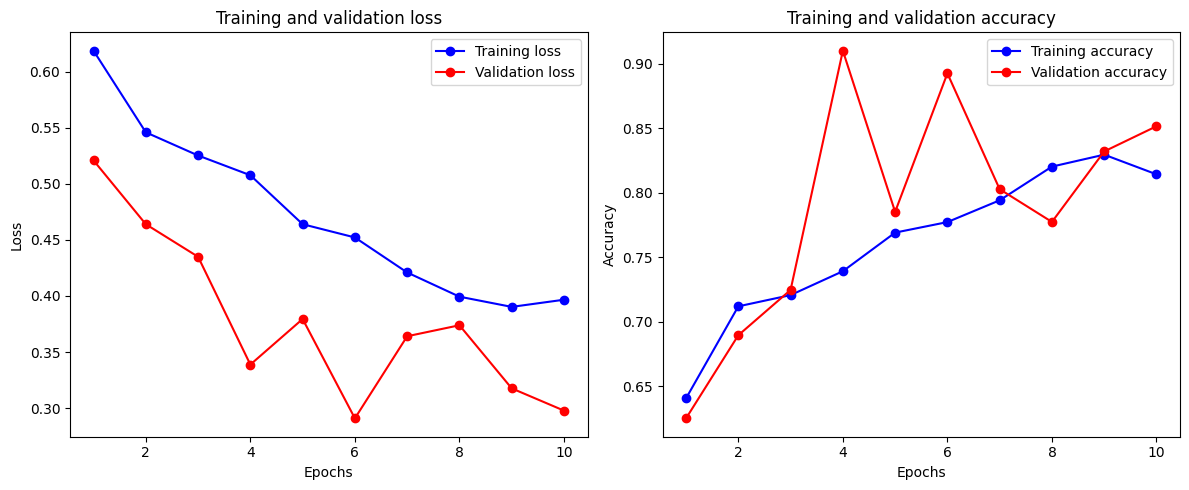

In [ ]:
# Visualization of loss and accuracy
epochs = range(1, epoch_num + 1, val_interval)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch_num + 1), epoch_loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_num + 1), epoch_acc_values, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

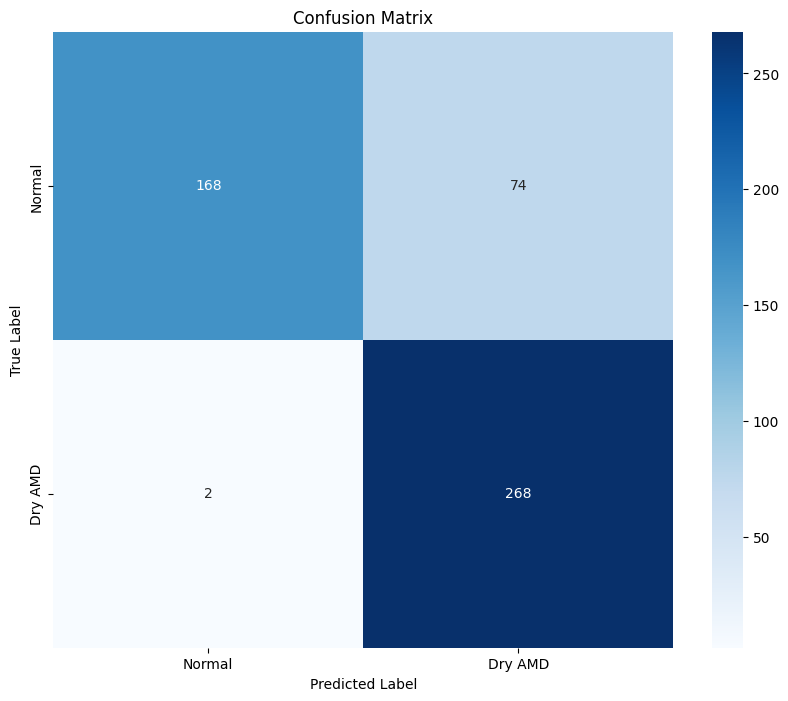

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# After obtaining predictions in the validation loop
y_true_cpu = y.cpu().numpy()  # Convert to numpy array
y_pred_cpu = y_pred.argmax(dim=1).cpu().numpy()  # Predicted labels

# Compute the confusion matrix
cm = confusion_matrix(y_true_cpu, y_pred_cpu)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### **9.2 VGG16 Model**

In [ ]:
# Initialize VGG16 model
from torchvision import models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)
model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model.classifier[6] = torch.nn.Linear(4096, num_class)
model = model.to(device)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 78.9MB/s]


In [ ]:
# Loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early stopping parameters
early_stop_patience = 5
early_stop_counter = 0
best_val_loss = float('inf')

9.2.1 Training VGG16

In [ ]:
# Initialize variables
epoch_num = 10  # Increased epochs for more training
val_interval = 1
vgg_best_accuracy = -1
best_accuracy_epoch = -1
vgg_best_auc = -1
best_auc_epoch = -1
best_precision = -1
best_recall = -1
best_f1 = -1
epoch_loss_values = []
epoch_acc_values = []
val_loss_values = []
act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class)
auc_metric = ROCAUCMetric()
metric_values = []
val_acc_values = []

# Path to save the model on Google Drive
save_path = '/content/drive/MyDrive/Dry AMD/Model metrics/vgg_best_metric_model.pth'

# Training loop with checkpointing
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    # Training phase
    model.train()
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        epoch_correct += (predicted == labels).sum().item()
        epoch_total += labels.size(0)

        print(f"{step}/{len(train_loader)}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_accuracy = epoch_correct / epoch_total
    epoch_loss_values.append(epoch_loss)
    epoch_acc_values.append(epoch_accuracy)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}, average accuracy: {epoch_accuracy:.4f}")

    # Validation phase
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        val_steps = 0

        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)

            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                outputs = model(val_images)
                val_loss += loss_function(outputs, val_labels).item()
                val_steps += 1
                y_pred = torch.cat([y_pred, outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            val_loss /= val_steps
            val_loss_values.append(val_loss)

            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            metric_values.append(auc_result)

            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            val_acc_values.append(acc_metric)

            # Compute precision, recall, and F1-score
            y_true_cpu = y.cpu().numpy()
            y_pred_cpu = y_pred.argmax(dim=1).cpu().numpy()
            precision = precision_score(y_true_cpu, y_pred_cpu, average='weighted')
            recall = recall_score(y_true_cpu, y_pred_cpu, average='weighted')
            f1 = f1_score(y_true_cpu, y_pred_cpu, average='weighted')

            # Update best metrics
            if auc_result > vgg_best_auc:
                vgg_best_auc = auc_result
                best_auc_epoch = epoch + 1

            if precision > best_precision:
                best_precision = precision
            if recall > best_recall:
                best_recall = recall
            if f1 > best_f1:
                best_f1 = f1
            if acc_metric > vgg_best_accuracy:
                vgg_best_accuracy = acc_metric
                best_accuracy_epoch = epoch + 1
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'vgg_best_accuracy': vgg_best_accuracy,
                    'best_accuracy_epoch': best_accuracy_epoch,
                    'vgg_best_auc': vgg_best_auc,
                    'best_auc_epoch': best_auc_epoch,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'best_f1': best_f1
                }, save_path)
                print('saved new best metric model')

            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} current precision: {precision:.4f}"
                  f" current recall: {recall:.4f} current F1-score: {f1:.4f} best AUC: {vgg_best_auc:.4f}"
                  f" at epoch: {best_auc_epoch} best accuracy: {vgg_best_accuracy:.4f}"
                  f" at epoch: {best_accuracy_epoch} best precision: {best_precision:.4f}"
                  f" best recall: {best_recall:.4f} best F1-score: {best_f1:.4f}")
            print(f"validation loss: {val_loss:.4f}")

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stop_patience:
                print("Early stopping triggered")
                break

            # Step the scheduler
            scheduler.step(val_loss)

    # If early stopping was triggered
    if early_stop_counter >= early_stop_patience:
        break

print(f"train completed, best AUC: {vgg_best_auc:.4f} at epoch: {best_auc_epoch}, "
      f"best accuracy: {vgg_best_accuracy:.4f} at epoch: {best_accuracy_epoch}, "
      f"best precision: {best_precision:.4f}, best recall: {best_recall:.4f}, "
      f"best F1-score: {best_f1:.4f}")

----------
epoch 1/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.6701
2/115, train_loss: 0.7246
3/115, train_loss: 0.6457
4/115, train_loss: 0.7365
5/115, train_loss: 0.6968
6/115, train_loss: 0.6999
7/115, train_loss: 0.7367
8/115, train_loss: 0.6642
9/115, train_loss: 0.7055
10/115, train_loss: 0.6839
11/115, train_loss: 0.6733
12/115, train_loss: 0.6655
13/115, train_loss: 0.7626
14/115, train_loss: 0.7253
15/115, train_loss: 0.7192
16/115, train_loss: 0.6695
17/115, train_loss: 0.5944
18/115, train_loss: 0.6506
19/115, train_loss: 0.6052
20/115, train_loss: 0.6601
21/115, train_loss: 0.7148
22/115, train_loss: 0.6850
23/115, train_loss: 0.6782
24/115, train_loss: 0.7375
25/115, train_loss: 0.6392
26/115, train_loss: 0.7480
27/115, train_loss: 0.7135
28/115, train_loss: 0.7073
29/115, train_loss: 0.7020
30/115, train_loss: 0.7011
31/115, train_loss: 0.6682
32/115, train_loss: 0.6693
33/115, train_loss: 0.6687
34/115, train_loss: 0.6713
35/115, train_loss: 0.6573
36/115, train_loss: 0.7304
37/115, train_loss: 0.6209
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.5961
2/115, train_loss: 0.5910
3/115, train_loss: 0.5245
4/115, train_loss: 0.6074
5/115, train_loss: 0.5369
6/115, train_loss: 0.4515
7/115, train_loss: 0.7411
8/115, train_loss: 0.5148
9/115, train_loss: 0.4972
10/115, train_loss: 0.6674
11/115, train_loss: 0.5878
12/115, train_loss: 0.5761
13/115, train_loss: 0.6093
14/115, train_loss: 0.5228
15/115, train_loss: 0.7414
16/115, train_loss: 0.5749
17/115, train_loss: 0.5863
18/115, train_loss: 0.6648
19/115, train_loss: 0.5049
20/115, train_loss: 0.5509
21/115, train_loss: 0.4205
22/115, train_loss: 0.5106
23/115, train_loss: 0.5984
24/115, train_loss: 0.5760
25/115, train_loss: 0.6541
26/115, train_loss: 0.5066
27/115, train_loss: 0.5512
28/115, train_loss: 0.5383
29/115, train_loss: 0.5582
30/115, train_loss: 0.3543
31/115, train_loss: 0.6601
32/115, train_loss: 0.4724
33/115, train_loss: 0.4671
34/115, train_loss: 0.3859
35/115, train_loss: 0.5526
36/115, train_loss: 0.4510
37/115, train_loss: 0.4967
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.3471
2/115, train_loss: 0.3816
3/115, train_loss: 0.3603
4/115, train_loss: 0.4482
5/115, train_loss: 0.4873
6/115, train_loss: 0.6207
7/115, train_loss: 0.4885
8/115, train_loss: 0.6465
9/115, train_loss: 0.3070
10/115, train_loss: 0.6336
11/115, train_loss: 0.4777
12/115, train_loss: 0.5389
13/115, train_loss: 0.3919
14/115, train_loss: 0.6888
15/115, train_loss: 0.5658
16/115, train_loss: 0.5863
17/115, train_loss: 0.4823
18/115, train_loss: 0.6879
19/115, train_loss: 0.4287
20/115, train_loss: 0.6461
21/115, train_loss: 0.4650
22/115, train_loss: 0.6169
23/115, train_loss: 0.4691
24/115, train_loss: 0.6179
25/115, train_loss: 0.6603
26/115, train_loss: 0.4138
27/115, train_loss: 0.5093
28/115, train_loss: 0.4396
29/115, train_loss: 0.3531
30/115, train_loss: 0.3516
31/115, train_loss: 0.6924
32/115, train_loss: 0.7095
33/115, train_loss: 0.4382
34/115, train_loss: 0.7620
35/115, train_loss: 0.4063
36/115, train_loss: 0.4643
37/115, train_loss: 0.6800
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.4202
epoch 3 average loss: 0.4874, average accuracy: 0.7402
saved new best metric model
current epoch: 3 current AUC: 0.9912 current accuracy: 0.9023 current precision: 0.9118 current recall: 0.9023 current F1-score: 0.9013 best AUC: 0.9912 at epoch: 3 best accuracy: 0.9023 at epoch: 3 best precision: 0.9118 best recall: 0.9023 best F1-score: 0.9013
validation loss: 0.2145
----------
epoch 4/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.4759
2/115, train_loss: 0.4078
3/115, train_loss: 0.5595
4/115, train_loss: 0.2743
5/115, train_loss: 0.5455
6/115, train_loss: 0.5787
7/115, train_loss: 0.3720
8/115, train_loss: 0.4500
9/115, train_loss: 0.3606
10/115, train_loss: 0.4989
11/115, train_loss: 0.3692
12/115, train_loss: 0.4371
13/115, train_loss: 0.6948
14/115, train_loss: 0.5226
15/115, train_loss: 0.4715
16/115, train_loss: 0.4821
17/115, train_loss: 0.4072
18/115, train_loss: 0.5037
19/115, train_loss: 0.4784
20/115, train_loss: 0.3594
21/115, train_loss: 0.3577
22/115, train_loss: 0.3597
23/115, train_loss: 0.3541
24/115, train_loss: 0.5175
25/115, train_loss: 0.4985
26/115, train_loss: 0.3061
27/115, train_loss: 0.4505
28/115, train_loss: 0.4801
29/115, train_loss: 0.5540
30/115, train_loss: 0.3373
31/115, train_loss: 0.3655
32/115, train_loss: 0.3399
33/115, train_loss: 0.4829
34/115, train_loss: 0.2985
35/115, train_loss: 0.3613
36/115, train_loss: 0.4015
37/115, train_loss: 0.4404
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.3825
epoch 4 average loss: 0.4125, average accuracy: 0.7958
saved new best metric model
current epoch: 4 current AUC: 0.9974 current accuracy: 0.9375 current precision: 0.9418 current recall: 0.9375 current F1-score: 0.9372 best AUC: 0.9974 at epoch: 4 best accuracy: 0.9375 at epoch: 4 best precision: 0.9418 best recall: 0.9375 best F1-score: 0.9372
validation loss: 0.1785
----------
epoch 5/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.5066
2/115, train_loss: 0.5676
3/115, train_loss: 0.4536
4/115, train_loss: 0.3162
5/115, train_loss: 0.4869
6/115, train_loss: 0.4448
7/115, train_loss: 0.2315
8/115, train_loss: 0.2473
9/115, train_loss: 0.2448
10/115, train_loss: 0.4096
11/115, train_loss: 0.3462
12/115, train_loss: 0.2711
13/115, train_loss: 0.2771
14/115, train_loss: 0.3737
15/115, train_loss: 0.4136
16/115, train_loss: 0.5459
17/115, train_loss: 0.4263
18/115, train_loss: 0.0497
19/115, train_loss: 0.4151
20/115, train_loss: 0.5155
21/115, train_loss: 0.4577
22/115, train_loss: 0.1666
23/115, train_loss: 0.6336
24/115, train_loss: 0.1985
25/115, train_loss: 0.2838
26/115, train_loss: 0.3620
27/115, train_loss: 0.4136
28/115, train_loss: 0.3992
29/115, train_loss: 0.2451
30/115, train_loss: 0.6251
31/115, train_loss: 0.3030
32/115, train_loss: 0.4217
33/115, train_loss: 0.4089
34/115, train_loss: 0.3464
35/115, train_loss: 0.2184
36/115, train_loss: 0.3721
37/115, train_loss: 0.2094
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.2516
2/115, train_loss: 0.2073
3/115, train_loss: 0.3363
4/115, train_loss: 0.2920
5/115, train_loss: 0.2574
6/115, train_loss: 0.2832
7/115, train_loss: 0.3640
8/115, train_loss: 0.4952
9/115, train_loss: 0.3247
10/115, train_loss: 0.3077
11/115, train_loss: 0.4234
12/115, train_loss: 0.3398
13/115, train_loss: 0.2599
14/115, train_loss: 0.4886
15/115, train_loss: 0.3205
16/115, train_loss: 0.3768
17/115, train_loss: 0.1678
18/115, train_loss: 0.4680
19/115, train_loss: 0.1556
20/115, train_loss: 0.5211
21/115, train_loss: 0.4714
22/115, train_loss: 0.4594
23/115, train_loss: 0.2727
24/115, train_loss: 0.1889
25/115, train_loss: 0.2784
26/115, train_loss: 0.3048
27/115, train_loss: 0.3334
28/115, train_loss: 0.2399
29/115, train_loss: 0.1553
30/115, train_loss: 0.3362
31/115, train_loss: 0.3256
32/115, train_loss: 0.2231
33/115, train_loss: 0.4965
34/115, train_loss: 0.1890
35/115, train_loss: 0.2368
36/115, train_loss: 0.4425
37/115, train_loss: 0.5413
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.1859
epoch 6 average loss: 0.3201, average accuracy: 0.8497
saved new best metric model
current epoch: 6 current AUC: 0.9969 current accuracy: 0.9668 current precision: 0.9671 current recall: 0.9668 current F1-score: 0.9668 best AUC: 0.9976 at epoch: 5 best accuracy: 0.9668 at epoch: 6 best precision: 0.9671 best recall: 0.9668 best F1-score: 0.9668
validation loss: 0.0893
----------
epoch 7/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.1572
2/115, train_loss: 0.2481
3/115, train_loss: 0.2817
4/115, train_loss: 0.3969
5/115, train_loss: 0.1770
6/115, train_loss: 0.2725
7/115, train_loss: 0.2671
8/115, train_loss: 0.4959
9/115, train_loss: 0.1939
10/115, train_loss: 0.1823
11/115, train_loss: 0.4522
12/115, train_loss: 0.2245
13/115, train_loss: 0.3574
14/115, train_loss: 0.1772
15/115, train_loss: 0.3084
16/115, train_loss: 0.3052
17/115, train_loss: 0.3004
18/115, train_loss: 0.4024
19/115, train_loss: 0.2973
20/115, train_loss: 0.2128
21/115, train_loss: 0.2139
22/115, train_loss: 0.2887
23/115, train_loss: 0.2528
24/115, train_loss: 0.3019
25/115, train_loss: 0.2367
26/115, train_loss: 0.4146
27/115, train_loss: 0.4840
28/115, train_loss: 0.5017
29/115, train_loss: 0.4722
30/115, train_loss: 0.2218
31/115, train_loss: 0.4098
32/115, train_loss: 0.3632
33/115, train_loss: 0.3965
34/115, train_loss: 0.2512
35/115, train_loss: 0.3926
36/115, train_loss: 0.2059
37/115, train_loss: 0.1177
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.1279
2/115, train_loss: 0.2871
3/115, train_loss: 0.3003
4/115, train_loss: 0.4289
5/115, train_loss: 0.0840
6/115, train_loss: 0.1856
7/115, train_loss: 0.2748
8/115, train_loss: 0.4078
9/115, train_loss: 0.2632
10/115, train_loss: 0.4057
11/115, train_loss: 0.2247
12/115, train_loss: 0.2682
13/115, train_loss: 0.2861
14/115, train_loss: 0.1792
15/115, train_loss: 0.2617
16/115, train_loss: 0.3585
17/115, train_loss: 0.2349
18/115, train_loss: 0.2873
19/115, train_loss: 0.6958
20/115, train_loss: 0.0959
21/115, train_loss: 0.4887
22/115, train_loss: 0.2070
23/115, train_loss: 0.3147
24/115, train_loss: 0.4643
25/115, train_loss: 0.2483
26/115, train_loss: 0.2536
27/115, train_loss: 0.1959
28/115, train_loss: 0.2667
29/115, train_loss: 0.2376
30/115, train_loss: 0.2203
31/115, train_loss: 0.5655
32/115, train_loss: 0.1863
33/115, train_loss: 0.2677
34/115, train_loss: 0.4203
35/115, train_loss: 0.3669
36/115, train_loss: 0.1263
37/115, train_loss: 0.3576
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.3750
epoch 8 average loss: 0.2873, average accuracy: 0.8709
current epoch: 8 current AUC: 0.9980 current accuracy: 0.8164 current precision: 0.8638 current recall: 0.8164 current F1-score: 0.8079 best AUC: 0.9980 at epoch: 8 best accuracy: 0.9668 at epoch: 6 best precision: 0.9671 best recall: 0.9668 best F1-score: 0.9668
validation loss: 0.3320
----------
epoch 9/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.2351
2/115, train_loss: 0.2144
3/115, train_loss: 0.4841
4/115, train_loss: 0.4453
5/115, train_loss: 0.4928
6/115, train_loss: 0.2582
7/115, train_loss: 0.1715
8/115, train_loss: 0.2625
9/115, train_loss: 0.3727
10/115, train_loss: 0.1760
11/115, train_loss: 0.4381
12/115, train_loss: 0.3399
13/115, train_loss: 0.4402
14/115, train_loss: 0.1845
15/115, train_loss: 0.4422
16/115, train_loss: 0.3498
17/115, train_loss: 0.2674
18/115, train_loss: 0.2166
19/115, train_loss: 0.2091
20/115, train_loss: 0.3266
21/115, train_loss: 0.5310
22/115, train_loss: 0.4459
23/115, train_loss: 0.4061
24/115, train_loss: 0.3811
25/115, train_loss: 0.3689
26/115, train_loss: 0.3531
27/115, train_loss: 0.1454
28/115, train_loss: 0.4642
29/115, train_loss: 0.2362
30/115, train_loss: 0.3196
31/115, train_loss: 0.2564
32/115, train_loss: 0.3156
33/115, train_loss: 0.2709
34/115, train_loss: 0.2730
35/115, train_loss: 0.2055
36/115, train_loss: 0.2348
37/115, train_loss: 0.1688
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.2023
epoch 9 average loss: 0.2768, average accuracy: 0.8807
current epoch: 9 current AUC: 0.9997 current accuracy: 0.9453 current precision: 0.9505 current recall: 0.9453 current F1-score: 0.9450 best AUC: 0.9997 at epoch: 9 best accuracy: 0.9668 at epoch: 6 best precision: 0.9671 best recall: 0.9668 best F1-score: 0.9668
validation loss: 0.1037
----------
epoch 10/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.1270
2/115, train_loss: 0.1464
3/115, train_loss: 0.1612
4/115, train_loss: 0.1326
5/115, train_loss: 0.1228
6/115, train_loss: 0.1047
7/115, train_loss: 0.1338
8/115, train_loss: 0.1541
9/115, train_loss: 0.1663
10/115, train_loss: 0.2309
11/115, train_loss: 0.1131
12/115, train_loss: 0.1767
13/115, train_loss: 0.4093
14/115, train_loss: 0.0965
15/115, train_loss: 0.4337
16/115, train_loss: 0.0755
17/115, train_loss: 0.1937
18/115, train_loss: 0.0610
19/115, train_loss: 0.2669
20/115, train_loss: 0.1538
21/115, train_loss: 0.3600
22/115, train_loss: 0.1681
23/115, train_loss: 0.3074
24/115, train_loss: 0.1516
25/115, train_loss: 0.2361
26/115, train_loss: 0.0757
27/115, train_loss: 0.3372
28/115, train_loss: 0.0718
29/115, train_loss: 0.2789
30/115, train_loss: 0.1471
31/115, train_loss: 0.1452
32/115, train_loss: 0.0544
33/115, train_loss: 0.1195
34/115, train_loss: 0.0983
35/115, train_loss: 0.2865
36/115, train_loss: 0.5820
37/115, train_loss: 0.5034
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.2485
epoch 10 average loss: 0.2311, average accuracy: 0.9014
saved new best metric model
current epoch: 10 current AUC: 0.9997 current accuracy: 0.9746 current precision: 0.9754 current recall: 0.9746 current F1-score: 0.9746 best AUC: 0.9997 at epoch: 9 best accuracy: 0.9746 at epoch: 10 best precision: 0.9754 best recall: 0.9746 best F1-score: 0.9746
validation loss: 0.0764
train completed, best AUC: 0.9997 at epoch: 9, best accuracy: 0.9746 at epoch: 10, best precision: 0.9754, best recall: 0.9746, best F1-score: 0.9746


In [ ]:
print(f'VGG16 best accuracy is : {vgg_best_accuracy}')

VGG16 best accuracy is : 0.974609375


9.2.2 Plot Loss and Accuracy Metric for VGG16

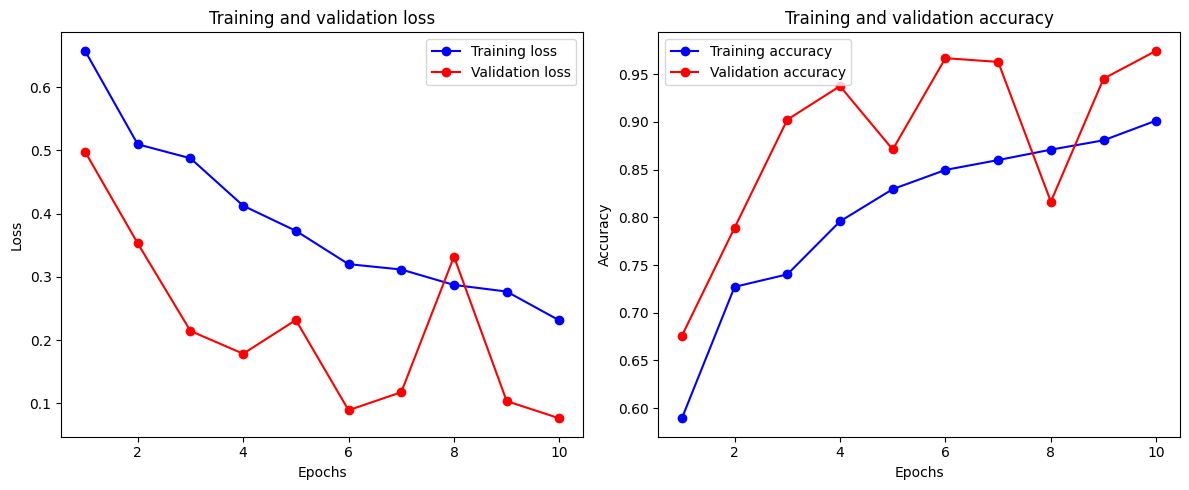

In [ ]:
# Visualization of loss and accuracy
epochs = range(1, epoch_num + 1, val_interval)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch_num + 1), epoch_loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_num + 1), epoch_acc_values, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


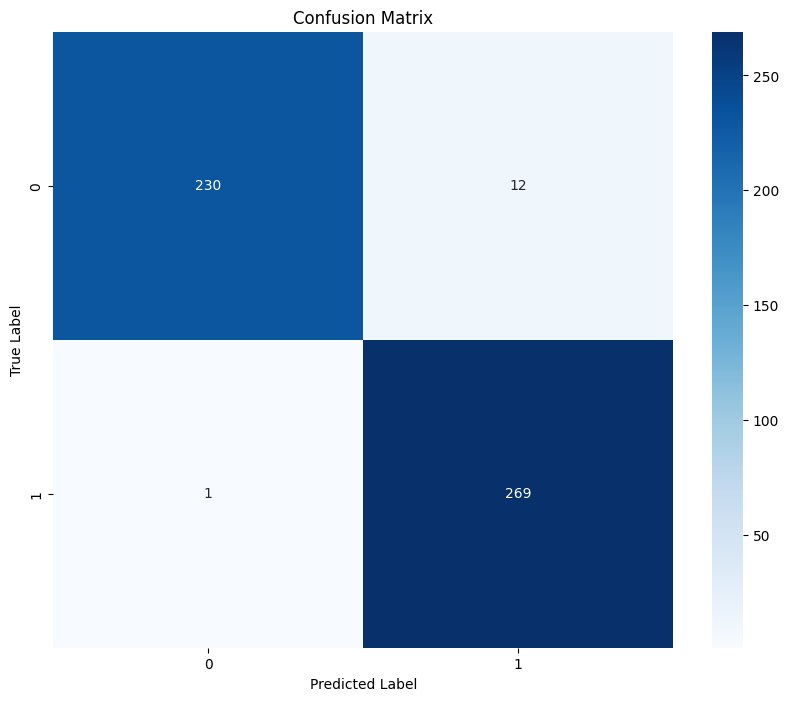

In [ ]:
# Generate confusion matrix at the end
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        outputs = model(val_images)
        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **9.3 ResNet 50**

In [ ]:
from torchvision import models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


9.3.1 Modifying Model Architecture for Grayscale Images and Adjusting Output Layer for Classification

In [ ]:
# Modify the first convolutional layer to accept 1 channel for grayscale images
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modify the fully connected layer to match the number of classes
model.fc = torch.nn.Linear(model.fc.in_features, num_class)
model = model.to(device)

In [ ]:
# Loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

9.3.2 Training ResNet 50

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize variables
epoch_num = 10
val_interval = 1
resnet_best_accuracy = -1
best_accuracy_epoch = -1
resnet_best_auc = -1
best_auc_epoch = -1
best_precision = -1
best_recall = -1
best_f1 = -1
epoch_loss_values = []
epoch_acc_values = []
val_loss_values = []
act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class)
auc_metric = ROCAUCMetric()
metric_values = []
val_acc_values = []

# Path to save the model on Google Drive
save_path = '/content/drive/MyDrive/Dry AMD/Model metrics/resnet_best_metric_model.pth'

# Training loop with checkpointing
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    # Training phase
    model.train()
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        epoch_correct += (predicted == labels).sum().item()
        epoch_total += labels.size(0)

        print(f"{step}/{len(train_loader)}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_accuracy = epoch_correct / epoch_total
    epoch_loss_values.append(epoch_loss)
    epoch_acc_values.append(epoch_accuracy)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}, average accuracy: {epoch_accuracy:.4f}")

    # Validation phase
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        val_steps = 0

        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)

            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                outputs = model(val_images)
                val_loss += loss_function(outputs, val_labels).item()
                val_steps += 1
                y_pred = torch.cat([y_pred, outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            val_loss /= val_steps
            val_loss_values.append(val_loss)

            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            metric_values.append(auc_result)

            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            val_acc_values.append(acc_metric)

            # Compute precision, recall, and F1-score
            y_true_cpu = y.cpu().numpy()
            y_pred_cpu = y_pred.argmax(dim=1).cpu().numpy()
            precision = precision_score(y_true_cpu, y_pred_cpu, average='weighted')
            recall = recall_score(y_true_cpu, y_pred_cpu, average='weighted')
            f1 = f1_score(y_true_cpu, y_pred_cpu, average='weighted')

            print(f"Epoch {epoch + 1} Validation AUC: {auc_result:.4f}, Best AUC: {resnet_best_auc:.4f}")
            print(f"Epoch {epoch + 1} Validation Accuracy: {acc_metric:.4f}, Best Accuracy: {resnet_best_accuracy:.4f}")
            print(f"Epoch {epoch + 1} Validation Precision: {precision:.4f}, Validation Recall: {recall:.4f}, Validation F1-score: {f1:.4f}")

            if auc_result > resnet_best_auc:
                resnet_best_auc = auc_result
                best_auc_epoch = epoch + 1
                print('Updated best AUC.')

            if acc_metric > resnet_best_accuracy:
                resnet_best_accuracy = acc_metric
                best_accuracy_epoch = epoch + 1
                print('Updated best accuracy.')

            if precision > best_precision:
                best_precision = precision
            if recall > best_recall:
                best_recall = recall
            if f1 > best_f1:
                best_f1 = f1
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'resnet_best_accuracy': resnet_best_accuracy,
                    'best_accuracy_epoch': best_accuracy_epoch,
                    'resnet_best_auc': resnet_best_auc,
                    'best_auc_epoch': best_auc_epoch,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'best_f1': best_f1
                }, save_path)
                print('Saved new best metric model.')

            print(f"Current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} current precision: {precision:.4f}"
                  f" current recall: {recall:.4f} current F1-score: {f1:.4f} best AUC: {resnet_best_auc:.4f}"
                  f" at epoch: {best_auc_epoch} best accuracy: {resnet_best_accuracy:.4f}"
                  f" at epoch: {best_accuracy_epoch} best precision: {best_precision:.4f}"
                  f" best recall: {best_recall:.4f} best F1-score: {best_f1:.4f}")
            print(f"Validation loss: {val_loss:.4f}")

print(f"Train completed, best AUC: {resnet_best_auc:.4f} at epoch: {best_auc_epoch}, best accuracy: {resnet_best_accuracy:.4f} at epoch: {best_accuracy_epoch}, best precision: {best_precision:.4f}, best recall: {best_recall:.4f}, best F1-score: {best_f1:.4f}")


----------
epoch 1/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.6594
2/115, train_loss: 0.8251
3/115, train_loss: 0.7074
4/115, train_loss: 0.6807
5/115, train_loss: 0.6511
6/115, train_loss: 0.6687
7/115, train_loss: 0.6513
8/115, train_loss: 0.7137
9/115, train_loss: 0.7302
10/115, train_loss: 0.7722
11/115, train_loss: 0.6138
12/115, train_loss: 0.6879
13/115, train_loss: 0.7535
14/115, train_loss: 0.5875
15/115, train_loss: 0.5154
16/115, train_loss: 0.6116
17/115, train_loss: 0.6219
18/115, train_loss: 0.5846
19/115, train_loss: 0.6741
20/115, train_loss: 0.6533
21/115, train_loss: 0.5559
22/115, train_loss: 0.5832
23/115, train_loss: 0.4994
24/115, train_loss: 0.6047
25/115, train_loss: 0.6417
26/115, train_loss: 0.5917
27/115, train_loss: 0.5413
28/115, train_loss: 0.6186
29/115, train_loss: 0.6407
30/115, train_loss: 0.6006
31/115, train_loss: 0.4925
32/115, train_loss: 0.6287
33/115, train_loss: 0.7075
34/115, train_loss: 0.5516
35/115, train_loss: 0.5312
36/115, train_loss: 0.5699
37/115, train_loss: 0.5572
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.4482
epoch 1 average loss: 0.5184, average accuracy: 0.7413
Epoch 1 Validation AUC: 0.9853, Best AUC: -1.0000
Epoch 1 Validation Accuracy: 0.8652, Best Accuracy: -1.0000
Epoch 1 Validation Precision: 0.8860, Validation Recall: 0.8652, Validation F1-score: 0.8624
Updated best AUC.
Updated best accuracy.
Saved new best metric model.
Current epoch: 1 current AUC: 0.9853 current accuracy: 0.8652 current precision: 0.8860 current recall: 0.8652 current F1-score: 0.8624 best AUC: 0.9853 at epoch: 1 best accuracy: 0.8652 at epoch: 1 best precision: 0.8860 best recall: 0.8652 best F1-score: 0.8624
Validation loss: 0.2802
----------
epoch 2/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.2521
2/115, train_loss: 0.3433
3/115, train_loss: 0.2773
4/115, train_loss: 0.3481
5/115, train_loss: 0.4077
6/115, train_loss: 0.3511
7/115, train_loss: 0.7293
8/115, train_loss: 0.4642
9/115, train_loss: 0.4919
10/115, train_loss: 0.3685
11/115, train_loss: 0.4680
12/115, train_loss: 0.3337
13/115, train_loss: 0.4540
14/115, train_loss: 0.2959
15/115, train_loss: 0.3342
16/115, train_loss: 0.4695
17/115, train_loss: 0.6394
18/115, train_loss: 0.4433
19/115, train_loss: 0.6155
20/115, train_loss: 0.4289
21/115, train_loss: 0.5559
22/115, train_loss: 0.2988
23/115, train_loss: 0.4294
24/115, train_loss: 0.3441
25/115, train_loss: 0.3037
26/115, train_loss: 0.3197
27/115, train_loss: 0.3322
28/115, train_loss: 0.2397
29/115, train_loss: 0.2359
30/115, train_loss: 0.3394
31/115, train_loss: 0.2746
32/115, train_loss: 0.5030
33/115, train_loss: 0.2059
34/115, train_loss: 0.2474
35/115, train_loss: 0.3385
36/115, train_loss: 0.2656
37/115, train_loss: 0.2466
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.2634
epoch 2 average loss: 0.3308, average accuracy: 0.8666
Epoch 2 Validation AUC: 0.9931, Best AUC: 0.9853
Epoch 2 Validation Accuracy: 0.9375, Best Accuracy: 0.8652
Epoch 2 Validation Precision: 0.9399, Validation Recall: 0.9375, Validation F1-score: 0.9373
Updated best AUC.
Updated best accuracy.
Saved new best metric model.
Current epoch: 2 current AUC: 0.9931 current accuracy: 0.9375 current precision: 0.9399 current recall: 0.9375 current F1-score: 0.9373 best AUC: 0.9931 at epoch: 2 best accuracy: 0.9375 at epoch: 2 best precision: 0.9399 best recall: 0.9375 best F1-score: 0.9373
Validation loss: 0.1701
----------
epoch 3/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.1455
2/115, train_loss: 0.3706
3/115, train_loss: 0.2503
4/115, train_loss: 0.2446
5/115, train_loss: 0.4301
6/115, train_loss: 0.2987
7/115, train_loss: 0.1905
8/115, train_loss: 0.2903
9/115, train_loss: 0.2751
10/115, train_loss: 0.0811
11/115, train_loss: 0.1008
12/115, train_loss: 0.1654
13/115, train_loss: 0.1009
14/115, train_loss: 0.2483
15/115, train_loss: 0.2938
16/115, train_loss: 0.2347
17/115, train_loss: 0.2235
18/115, train_loss: 0.1169
19/115, train_loss: 0.2030
20/115, train_loss: 0.1723
21/115, train_loss: 0.1911
22/115, train_loss: 0.1290
23/115, train_loss: 0.1856
24/115, train_loss: 0.1538
25/115, train_loss: 0.2306
26/115, train_loss: 0.3059
27/115, train_loss: 0.3118
28/115, train_loss: 0.1945
29/115, train_loss: 0.2397
30/115, train_loss: 0.3436
31/115, train_loss: 0.1351
32/115, train_loss: 0.2591
33/115, train_loss: 0.1808
34/115, train_loss: 0.3176
35/115, train_loss: 0.2517
36/115, train_loss: 0.1392
37/115, train_loss: 0.3236
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.2686
epoch 3 average loss: 0.2391, average accuracy: 0.9041
Epoch 3 Validation AUC: 0.9957, Best AUC: 0.9931
Epoch 3 Validation Accuracy: 0.9121, Best Accuracy: 0.9375
Epoch 3 Validation Precision: 0.9235, Validation Recall: 0.9121, Validation F1-score: 0.9111
Updated best AUC.
Current epoch: 3 current AUC: 0.9957 current accuracy: 0.9121 current precision: 0.9235 current recall: 0.9121 current F1-score: 0.9111 best AUC: 0.9957 at epoch: 3 best accuracy: 0.9375 at epoch: 2 best precision: 0.9399 best recall: 0.9375 best F1-score: 0.9373
Validation loss: 0.1984
----------
epoch 4/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.4330
2/115, train_loss: 0.4721
3/115, train_loss: 0.1887
4/115, train_loss: 0.1100
5/115, train_loss: 0.3408
6/115, train_loss: 0.2232
7/115, train_loss: 0.2182
8/115, train_loss: 0.1319
9/115, train_loss: 0.2664
10/115, train_loss: 0.2051
11/115, train_loss: 0.1136
12/115, train_loss: 0.2192
13/115, train_loss: 0.1738
14/115, train_loss: 0.0696
15/115, train_loss: 0.1965
16/115, train_loss: 0.1112
17/115, train_loss: 0.2736
18/115, train_loss: 0.1635
19/115, train_loss: 0.0847
20/115, train_loss: 0.1239
21/115, train_loss: 0.0933
22/115, train_loss: 0.1525
23/115, train_loss: 0.3040
24/115, train_loss: 0.1398
25/115, train_loss: 0.6132
26/115, train_loss: 0.1195
27/115, train_loss: 0.2091
28/115, train_loss: 0.1035
29/115, train_loss: 0.0868
30/115, train_loss: 0.1944
31/115, train_loss: 0.5334
32/115, train_loss: 0.1449
33/115, train_loss: 0.1195
34/115, train_loss: 0.2763
35/115, train_loss: 0.0358
36/115, train_loss: 0.1492
37/115, train_loss: 0.2304
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.1706
2/115, train_loss: 0.1224
3/115, train_loss: 0.2920
4/115, train_loss: 0.1502
5/115, train_loss: 0.2017
6/115, train_loss: 0.3465
7/115, train_loss: 0.2587
8/115, train_loss: 0.0671
9/115, train_loss: 0.3366
10/115, train_loss: 0.1469
11/115, train_loss: 0.0768
12/115, train_loss: 0.2738
13/115, train_loss: 0.1437
14/115, train_loss: 0.2105
15/115, train_loss: 0.0944
16/115, train_loss: 0.3524
17/115, train_loss: 0.1219
18/115, train_loss: 0.1858
19/115, train_loss: 0.0444
20/115, train_loss: 0.2655
21/115, train_loss: 0.1685
22/115, train_loss: 0.3096
23/115, train_loss: 0.2005
24/115, train_loss: 0.2166
25/115, train_loss: 0.0221
26/115, train_loss: 0.1326
27/115, train_loss: 0.1807
28/115, train_loss: 0.1505
29/115, train_loss: 0.0643
30/115, train_loss: 0.2204
31/115, train_loss: 0.1884
32/115, train_loss: 0.2776
33/115, train_loss: 0.1031
34/115, train_loss: 0.2150
35/115, train_loss: 0.1278
36/115, train_loss: 0.1354
37/115, train_loss: 0.1694
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.0402
epoch 5 average loss: 0.1717, average accuracy: 0.9254
Epoch 5 Validation AUC: 0.9979, Best AUC: 0.9989
Epoch 5 Validation Accuracy: 0.9688, Best Accuracy: 0.9492
Epoch 5 Validation Precision: 0.9697, Validation Recall: 0.9688, Validation F1-score: 0.9687
Updated best accuracy.
Saved new best metric model.
Current epoch: 5 current AUC: 0.9979 current accuracy: 0.9688 current precision: 0.9697 current recall: 0.9688 current F1-score: 0.9687 best AUC: 0.9989 at epoch: 4 best accuracy: 0.9688 at epoch: 5 best precision: 0.9697 best recall: 0.9688 best F1-score: 0.9687
Validation loss: 0.0862
----------
epoch 6/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.0900
2/115, train_loss: 0.0828
3/115, train_loss: 0.1527
4/115, train_loss: 0.2563
5/115, train_loss: 0.1261
6/115, train_loss: 0.2093
7/115, train_loss: 0.2068
8/115, train_loss: 0.3535
9/115, train_loss: 0.4605
10/115, train_loss: 0.0649
11/115, train_loss: 0.0993
12/115, train_loss: 0.0580
13/115, train_loss: 0.1682
14/115, train_loss: 0.1195
15/115, train_loss: 0.2920
16/115, train_loss: 0.2009
17/115, train_loss: 0.0386
18/115, train_loss: 0.0862
19/115, train_loss: 0.1255
20/115, train_loss: 0.2749
21/115, train_loss: 0.1693
22/115, train_loss: 0.2155
23/115, train_loss: 0.1805
24/115, train_loss: 0.2275
25/115, train_loss: 0.0715
26/115, train_loss: 0.0796
27/115, train_loss: 0.0730
28/115, train_loss: 0.1381
29/115, train_loss: 0.0858
30/115, train_loss: 0.2330
31/115, train_loss: 0.1679
32/115, train_loss: 0.0873
33/115, train_loss: 0.0888
34/115, train_loss: 0.0825
35/115, train_loss: 0.1664
36/115, train_loss: 0.0694
37/115, train_loss: 0.0830
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.1894
2/115, train_loss: 0.1168
3/115, train_loss: 0.2617
4/115, train_loss: 0.1147
5/115, train_loss: 0.3263
6/115, train_loss: 0.1563
7/115, train_loss: 0.1676
8/115, train_loss: 0.1788
9/115, train_loss: 0.2023
10/115, train_loss: 0.1655
11/115, train_loss: 0.0811
12/115, train_loss: 0.0569
13/115, train_loss: 0.1546
14/115, train_loss: 0.0542
15/115, train_loss: 0.2171
16/115, train_loss: 0.0674
17/115, train_loss: 0.1198
18/115, train_loss: 0.0326
19/115, train_loss: 0.0646
20/115, train_loss: 0.4646
21/115, train_loss: 0.2656
22/115, train_loss: 0.1064
23/115, train_loss: 0.0412
24/115, train_loss: 0.0856
25/115, train_loss: 0.0147
26/115, train_loss: 0.0573
27/115, train_loss: 0.0812
28/115, train_loss: 0.0607
29/115, train_loss: 0.1473
30/115, train_loss: 0.0925
31/115, train_loss: 0.3255
32/115, train_loss: 0.0369
33/115, train_loss: 0.2400
34/115, train_loss: 0.2314
35/115, train_loss: 0.3156
36/115, train_loss: 0.0129
37/115, train_loss: 0.1173
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.0150
epoch 7 average loss: 0.1436, average accuracy: 0.9466
Epoch 7 Validation AUC: 0.9979, Best AUC: 0.9989
Epoch 7 Validation Accuracy: 0.9785, Best Accuracy: 0.9688
Epoch 7 Validation Precision: 0.9786, Validation Recall: 0.9785, Validation F1-score: 0.9785
Updated best accuracy.
Saved new best metric model.
Current epoch: 7 current AUC: 0.9979 current accuracy: 0.9785 current precision: 0.9786 current recall: 0.9785 current F1-score: 0.9785 best AUC: 0.9989 at epoch: 4 best accuracy: 0.9785 at epoch: 7 best precision: 0.9786 best recall: 0.9785 best F1-score: 0.9785
Validation loss: 0.0616
----------
epoch 8/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.1327
2/115, train_loss: 0.0488
3/115, train_loss: 0.0139
4/115, train_loss: 0.1279
5/115, train_loss: 0.0442
6/115, train_loss: 0.0510
7/115, train_loss: 0.1141
8/115, train_loss: 0.2423
9/115, train_loss: 0.0490
10/115, train_loss: 0.1217
11/115, train_loss: 0.1112
12/115, train_loss: 0.0950
13/115, train_loss: 0.1101
14/115, train_loss: 0.0272
15/115, train_loss: 0.1183
16/115, train_loss: 0.0459
17/115, train_loss: 0.1308
18/115, train_loss: 0.0641
19/115, train_loss: 0.1349
20/115, train_loss: 0.2248
21/115, train_loss: 0.1845
22/115, train_loss: 0.2672
23/115, train_loss: 0.0702
24/115, train_loss: 0.0644
25/115, train_loss: 0.0808
26/115, train_loss: 0.1856
27/115, train_loss: 0.1349
28/115, train_loss: 0.0291
29/115, train_loss: 0.0406
30/115, train_loss: 0.1000
31/115, train_loss: 0.0469
32/115, train_loss: 0.2501
33/115, train_loss: 0.1806
34/115, train_loss: 0.1885
35/115, train_loss: 0.1440
36/115, train_loss: 0.3888
37/115, train_loss: 0.1081
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.0912
2/115, train_loss: 0.1035
3/115, train_loss: 0.1554
4/115, train_loss: 0.0729
5/115, train_loss: 0.0775
6/115, train_loss: 0.0612
7/115, train_loss: 0.0882
8/115, train_loss: 0.0229
9/115, train_loss: 0.0440
10/115, train_loss: 0.0714
11/115, train_loss: 0.0193
12/115, train_loss: 0.4066
13/115, train_loss: 0.0651
14/115, train_loss: 0.1107
15/115, train_loss: 0.0354
16/115, train_loss: 0.1581
17/115, train_loss: 0.1217
18/115, train_loss: 0.0201
19/115, train_loss: 0.1031
20/115, train_loss: 0.1320
21/115, train_loss: 0.0164
22/115, train_loss: 0.0761
23/115, train_loss: 0.0607
24/115, train_loss: 0.1268
25/115, train_loss: 0.4723
26/115, train_loss: 0.1891
27/115, train_loss: 0.1254
28/115, train_loss: 0.3676
29/115, train_loss: 0.2207
30/115, train_loss: 0.1671
31/115, train_loss: 0.0478
32/115, train_loss: 0.0474
33/115, train_loss: 0.1053
34/115, train_loss: 0.1947
35/115, train_loss: 0.2442
36/115, train_loss: 0.1018
37/115, train_loss: 0.0455
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.0176
2/115, train_loss: 0.4674
3/115, train_loss: 0.1145
4/115, train_loss: 0.0276
5/115, train_loss: 0.1470
6/115, train_loss: 0.0873
7/115, train_loss: 0.1766
8/115, train_loss: 0.1554
9/115, train_loss: 0.1544
10/115, train_loss: 0.0320
11/115, train_loss: 0.2972
12/115, train_loss: 0.1493
13/115, train_loss: 0.1074
14/115, train_loss: 0.3211
15/115, train_loss: 0.1191
16/115, train_loss: 0.1042
17/115, train_loss: 0.0197
18/115, train_loss: 0.0537
19/115, train_loss: 0.1030
20/115, train_loss: 0.0535
21/115, train_loss: 0.1135
22/115, train_loss: 0.1364
23/115, train_loss: 0.0207
24/115, train_loss: 0.2466
25/115, train_loss: 0.0787
26/115, train_loss: 0.1103
27/115, train_loss: 0.2093
28/115, train_loss: 0.0398
29/115, train_loss: 0.0133
30/115, train_loss: 0.2026
31/115, train_loss: 0.0285
32/115, train_loss: 0.2750
33/115, train_loss: 0.0971
34/115, train_loss: 0.1316
35/115, train_loss: 0.0502
36/115, train_loss: 0.0178
37/115, train_loss: 0.0965
38/115, tr

9.3.3 Plot Loss and Accuracy Metric for Resnet 50

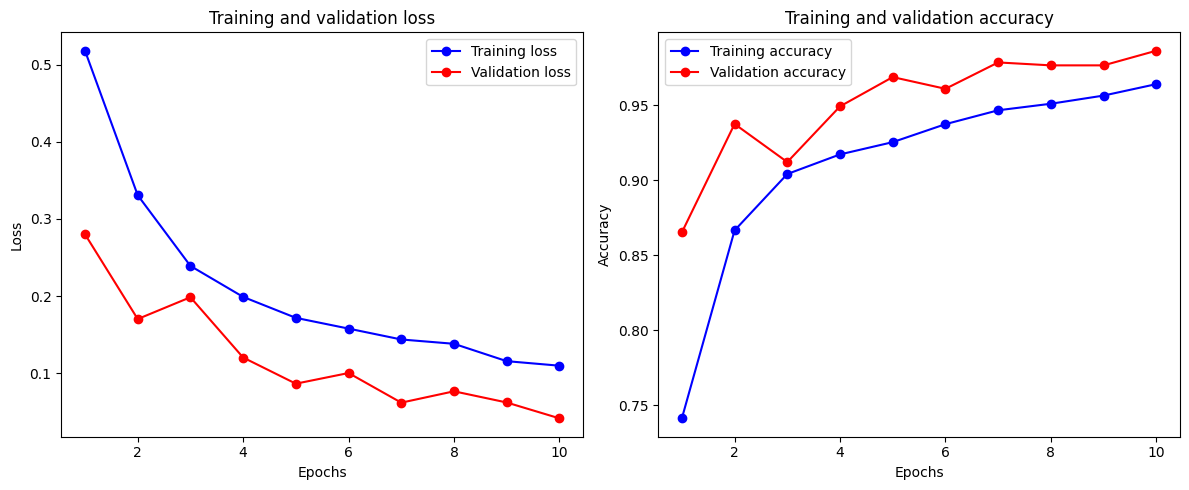

In [ ]:
# Visualization of loss and accuracy
epochs = range(1, epoch_num + 1, val_interval)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch_num + 1), epoch_loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_num + 1), epoch_acc_values, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


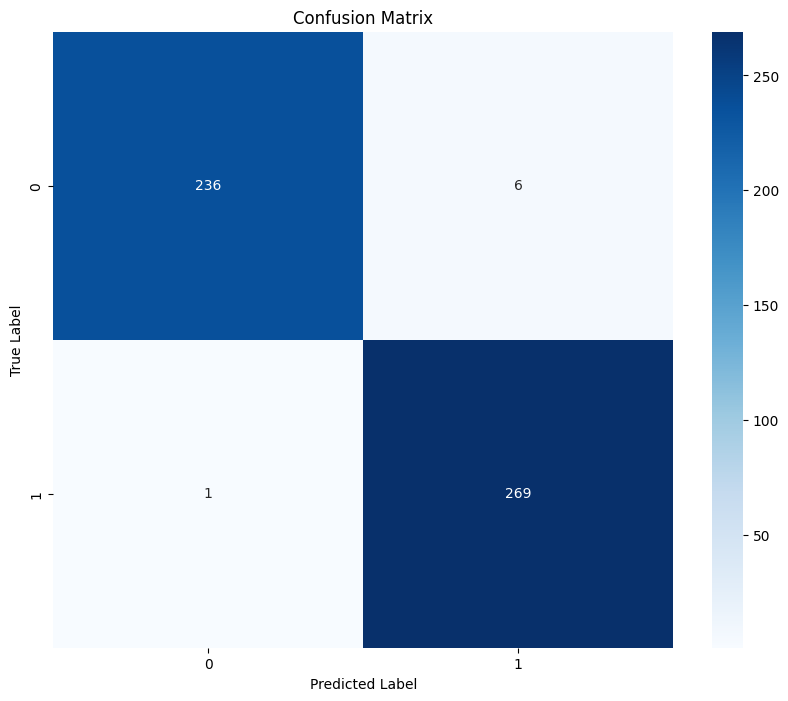

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate confusion matrix at the end
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        outputs = model(val_images)
        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(f'Resnet Best Accuracy: {resnet_best_accuracy}')
print(f'Resnet Best Precision: {best_precision}')
print(f'Resnet Best Recall: {best_recall}')
print(f'Resnet Best F1-Score: {best_f1}')

Resnet Best Accuracy: 0.986328125
Resnet Best Precision: 0.9864999880130418
Resnet Best Recall: 0.986328125
Resnet Best F1-Score: 0.9863194836815996


Load ResNet

### **9.4 EfficientNet**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from monai.transforms import Compose, Activations, AsDiscrete
from monai.metrics import ROCAUCMetric
from torch.utils.data import DataLoader

# Load the pre-trained EfficientNet-B0 model
model_efficientnet = models.efficientnet_b0(pretrained=True)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 97.9MB/s]


9.4.1  Adjusting EfficientNet Architecture for Grayscale Images and Customizing Output Layer for Classification

In [ ]:
# Modify the first convolutional layer to accept 1 channel for grayscale images
model_efficientnet.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

# Modify the fully connected layer to match the number of classes
model_efficientnet.classifier[1] = nn.Linear(model_efficientnet.classifier[1].in_features, num_class)


In [ ]:
# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_efficientnet = model_efficientnet.to(device)


In [ ]:
# Loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_efficientnet.parameters(), lr=1e-5)

9.4.2 Training and Validation of EfficientNet

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize variables
epoch_num = 10
val_interval = 1
efficientnet_best_auc = -1
efficientnet_best_accuracy = -1
best_auc_epoch = -1
best_accuracy_epoch = -1
best_precision = -1
best_recall = -1
best_f1 = -1
epoch_loss_values = []
epoch_acc_values = []
val_loss_values = []
act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class)
auc_metric = ROCAUCMetric()
metric_values = []
val_acc_values = []

# Path to save the model on Google Drive
save_path = '/content/drive/MyDrive/Dry AMD/Model metrics/efficientnet_best_metric_model.pth'

# Training loop with checkpointing
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    # Training phase
    model_efficientnet.train()
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model_efficientnet(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        epoch_correct += (predicted == labels).sum().item()
        epoch_total += labels.size(0)

        print(f"{step}/{len(train_loader)}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_accuracy = epoch_correct / epoch_total
    epoch_loss_values.append(epoch_loss)
    epoch_acc_values.append(epoch_accuracy)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}, average accuracy: {epoch_accuracy:.4f}")

    # Validation phase
    if (epoch + 1) % val_interval == 0:
        model_efficientnet.eval()
        val_loss = 0
        val_steps = 0

        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)

            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                outputs = model_efficientnet(val_images)
                val_loss += loss_function(outputs, val_labels).item()
                val_steps += 1
                y_pred = torch.cat([y_pred, outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            val_loss /= val_steps
            val_loss_values.append(val_loss)

            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            metric_values.append(auc_result)

            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            val_acc_values.append(acc_metric)

            # Compute precision, recall, and F1-score
            y_true_cpu = y.cpu().numpy()
            y_pred_cpu = y_pred.argmax(dim=1).cpu().numpy()
            precision = precision_score(y_true_cpu, y_pred_cpu, average='weighted')
            recall = recall_score(y_true_cpu, y_pred_cpu, average='weighted')
            f1 = f1_score(y_true_cpu, y_pred_cpu, average='weighted')

            print(f"Epoch {epoch + 1} Validation AUC: {auc_result:.4f}, Best AUC: {efficientnet_best_auc:.4f}")
            print(f"Epoch {epoch + 1} Validation Accuracy: {acc_metric:.4f}, Best Accuracy: {efficientnet_best_accuracy:.4f}")
            print(f"Epoch {epoch + 1} Validation Precision: {precision:.4f}, Validation Recall: {recall:.4f}, Validation F1-score: {f1:.4f}")

            if auc_result > efficientnet_best_auc:
                efficientnet_best_auc = auc_result
                best_auc_epoch = epoch + 1
                print('Updated best AUC.')

            if acc_metric > efficientnet_best_accuracy:
                efficientnet_best_accuracy = acc_metric
                best_accuracy_epoch = epoch + 1
                print('Updated best accuracy.')

            if precision > best_precision:
                best_precision = precision
            if recall > best_recall:
                best_recall = recall
            if f1 > best_f1:
                best_f1 = f1
                torch.save({
                    'model_state_dict': model_efficientnet.state_dict(),
                    'efficientnet_best_accuracy': efficientnet_best_accuracy,
                    'best_accuracy_epoch': best_accuracy_epoch,
                    'efficientnet_best_auc': efficientnet_best_auc,
                    'best_auc_epoch': best_auc_epoch,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'best_f1': best_f1
                }, save_path)
                print('Saved new best metric model.')

            print(f"Current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} current precision: {precision:.4f}"
                  f" current recall: {recall:.4f} current F1-score: {f1:.4f} best AUC: {efficientnet_best_auc:.4f}"
                  f" at epoch: {best_auc_epoch} best accuracy: {efficientnet_best_accuracy:.4f}"
                  f" at epoch: {best_accuracy_epoch} best precision: {best_precision:.4f}"
                  f" best recall: {best_recall:.4f} best F1-score: {best_f1:.4f}")
            print(f"Validation loss: {val_loss:.4f}")

print(f"Train completed, best AUC: {efficientnet_best_auc:.4f} at epoch: {best_auc_epoch}, best accuracy: {efficientnet_best_accuracy:.4f} at epoch: {best_accuracy_epoch}, best precision: {best_precision:.4f}, best recall: {best_recall:.4f}, best F1-score: {best_f1:.4f}")


----------
epoch 1/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.6572
2/115, train_loss: 0.6738
3/115, train_loss: 0.7184
4/115, train_loss: 0.7141
5/115, train_loss: 0.7120
6/115, train_loss: 0.6827
7/115, train_loss: 0.7140
8/115, train_loss: 0.6858
9/115, train_loss: 0.7403
10/115, train_loss: 0.6856
11/115, train_loss: 0.6835
12/115, train_loss: 0.7006
13/115, train_loss: 0.7147
14/115, train_loss: 0.6895
15/115, train_loss: 0.6424
16/115, train_loss: 0.6947
17/115, train_loss: 0.6836
18/115, train_loss: 0.6692
19/115, train_loss: 0.6931
20/115, train_loss: 0.7075
21/115, train_loss: 0.6902
22/115, train_loss: 0.6604
23/115, train_loss: 0.6910
24/115, train_loss: 0.6524
25/115, train_loss: 0.6910
26/115, train_loss: 0.6867
27/115, train_loss: 0.6589
28/115, train_loss: 0.6738
29/115, train_loss: 0.6815
30/115, train_loss: 0.6887
31/115, train_loss: 0.6604
32/115, train_loss: 0.6967
33/115, train_loss: 0.6864
34/115, train_loss: 0.6561
35/115, train_loss: 0.6888
36/115, train_loss: 0.7158
37/115, train_loss: 0.7140
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.5913
epoch 1 average loss: 0.6622, average accuracy: 0.6078
Epoch 1 Validation AUC: 0.9681, Best AUC: -1.0000
Epoch 1 Validation Accuracy: 0.7500, Best Accuracy: -1.0000
Epoch 1 Validation Precision: 0.8168, Validation Recall: 0.7500, Validation F1-score: 0.7315
Updated best AUC.
Updated best accuracy.
Saved new best metric model.
Current epoch: 1 current AUC: 0.9681 current accuracy: 0.7500 current precision: 0.8168 current recall: 0.7500 current F1-score: 0.7315 best AUC: 0.9681 at epoch: 1 best accuracy: 0.7500 at epoch: 1 best precision: 0.8168 best recall: 0.7500 best F1-score: 0.7315
Validation loss: 0.5340
----------
epoch 2/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.6198
2/115, train_loss: 0.5592
3/115, train_loss: 0.6022
4/115, train_loss: 0.5865
5/115, train_loss: 0.5919
6/115, train_loss: 0.6642
7/115, train_loss: 0.6135
8/115, train_loss: 0.6177
9/115, train_loss: 0.6179
10/115, train_loss: 0.6230
11/115, train_loss: 0.6265
12/115, train_loss: 0.5707
13/115, train_loss: 0.5931
14/115, train_loss: 0.6071
15/115, train_loss: 0.6247
16/115, train_loss: 0.6591
17/115, train_loss: 0.6436
18/115, train_loss: 0.5182
19/115, train_loss: 0.6452
20/115, train_loss: 0.5377
21/115, train_loss: 0.5994
22/115, train_loss: 0.6194
23/115, train_loss: 0.6181
24/115, train_loss: 0.6742
25/115, train_loss: 0.5899
26/115, train_loss: 0.5716
27/115, train_loss: 0.6102
28/115, train_loss: 0.5949
29/115, train_loss: 0.6384
30/115, train_loss: 0.5823
31/115, train_loss: 0.5587
32/115, train_loss: 0.6013
33/115, train_loss: 0.6602
34/115, train_loss: 0.6343
35/115, train_loss: 0.5840
36/115, train_loss: 0.5779
37/115, train_loss: 0.5505
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.5970
2/115, train_loss: 0.5504
3/115, train_loss: 0.5694
4/115, train_loss: 0.4861
5/115, train_loss: 0.5079
6/115, train_loss: 0.5153
7/115, train_loss: 0.5626
8/115, train_loss: 0.5119
9/115, train_loss: 0.5396
10/115, train_loss: 0.5335
11/115, train_loss: 0.6072
12/115, train_loss: 0.5774
13/115, train_loss: 0.5709
14/115, train_loss: 0.6011
15/115, train_loss: 0.5204
16/115, train_loss: 0.5294
17/115, train_loss: 0.4257
18/115, train_loss: 0.5582
19/115, train_loss: 0.4814
20/115, train_loss: 0.4745
21/115, train_loss: 0.5432
22/115, train_loss: 0.5690
23/115, train_loss: 0.5234
24/115, train_loss: 0.5085
25/115, train_loss: 0.5465
26/115, train_loss: 0.5595
27/115, train_loss: 0.6183
28/115, train_loss: 0.4871
29/115, train_loss: 0.5002
30/115, train_loss: 0.5172
31/115, train_loss: 0.4659
32/115, train_loss: 0.6019
33/115, train_loss: 0.5425
34/115, train_loss: 0.5446
35/115, train_loss: 0.5288
36/115, train_loss: 0.5150
37/115, train_loss: 0.5782
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.3948
epoch 3 average loss: 0.5110, average accuracy: 0.7598
Epoch 3 Validation AUC: 0.9877, Best AUC: 0.9808
Epoch 3 Validation Accuracy: 0.8164, Best Accuracy: 0.7637
Epoch 3 Validation Precision: 0.8614, Validation Recall: 0.8164, Validation F1-score: 0.8082
Updated best AUC.
Updated best accuracy.
Saved new best metric model.
Current epoch: 3 current AUC: 0.9877 current accuracy: 0.8164 current precision: 0.8614 current recall: 0.8164 current F1-score: 0.8082 best AUC: 0.9877 at epoch: 3 best accuracy: 0.8164 at epoch: 3 best precision: 0.8614 best recall: 0.8164 best F1-score: 0.8082
Validation loss: 0.3421
----------
epoch 4/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.5206
2/115, train_loss: 0.4378
3/115, train_loss: 0.5120
4/115, train_loss: 0.4255
5/115, train_loss: 0.4690
6/115, train_loss: 0.4493
7/115, train_loss: 0.5991
8/115, train_loss: 0.4363
9/115, train_loss: 0.5487
10/115, train_loss: 0.4645
11/115, train_loss: 0.6125
12/115, train_loss: 0.5987
13/115, train_loss: 0.4741
14/115, train_loss: 0.4025
15/115, train_loss: 0.5567
16/115, train_loss: 0.5158
17/115, train_loss: 0.4421
18/115, train_loss: 0.5667
19/115, train_loss: 0.3594
20/115, train_loss: 0.3700
21/115, train_loss: 0.4709
22/115, train_loss: 0.6665
23/115, train_loss: 0.5019
24/115, train_loss: 0.3676
25/115, train_loss: 0.5400
26/115, train_loss: 0.4998
27/115, train_loss: 0.4453
28/115, train_loss: 0.4662
29/115, train_loss: 0.5029
30/115, train_loss: 0.4650
31/115, train_loss: 0.4504
32/115, train_loss: 0.3888
33/115, train_loss: 0.4233
34/115, train_loss: 0.4554
35/115, train_loss: 0.4710
36/115, train_loss: 0.5318
37/115, train_loss: 0.4651
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.2806
epoch 4 average loss: 0.4582, average accuracy: 0.8028
Epoch 4 Validation AUC: 0.9876, Best AUC: 0.9877
Epoch 4 Validation Accuracy: 0.8477, Best Accuracy: 0.8164
Epoch 4 Validation Precision: 0.8725, Validation Recall: 0.8477, Validation F1-score: 0.8437
Updated best accuracy.
Saved new best metric model.
Current epoch: 4 current AUC: 0.9876 current accuracy: 0.8477 current precision: 0.8725 current recall: 0.8477 current F1-score: 0.8437 best AUC: 0.9877 at epoch: 3 best accuracy: 0.8477 at epoch: 4 best precision: 0.8725 best recall: 0.8477 best F1-score: 0.8437
Validation loss: 0.2672
----------
epoch 5/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.3426
2/115, train_loss: 0.3734
3/115, train_loss: 0.4202
4/115, train_loss: 0.4671
5/115, train_loss: 0.3089
6/115, train_loss: 0.4288
7/115, train_loss: 0.3523
8/115, train_loss: 0.4646
9/115, train_loss: 0.2695
10/115, train_loss: 0.3504
11/115, train_loss: 0.5554
12/115, train_loss: 0.5928
13/115, train_loss: 0.3447
14/115, train_loss: 0.5250
15/115, train_loss: 0.4435
16/115, train_loss: 0.2650
17/115, train_loss: 0.4578
18/115, train_loss: 0.3834
19/115, train_loss: 0.4800
20/115, train_loss: 0.2643
21/115, train_loss: 0.5367
22/115, train_loss: 0.5708
23/115, train_loss: 0.3958
24/115, train_loss: 0.4111
25/115, train_loss: 0.3602
26/115, train_loss: 0.3653
27/115, train_loss: 0.4820
28/115, train_loss: 0.4368
29/115, train_loss: 0.4039
30/115, train_loss: 0.3531
31/115, train_loss: 0.3638
32/115, train_loss: 0.5155
33/115, train_loss: 0.4358
34/115, train_loss: 0.4143
35/115, train_loss: 0.4780
36/115, train_loss: 0.4093
37/115, train_loss: 0.3296
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.4719
epoch 5 average loss: 0.4076, average accuracy: 0.8181
Epoch 5 Validation AUC: 0.9923, Best AUC: 0.9877
Epoch 5 Validation Accuracy: 0.8906, Best Accuracy: 0.8477
Epoch 5 Validation Precision: 0.9040, Validation Recall: 0.8906, Validation F1-score: 0.8891
Updated best AUC.
Updated best accuracy.
Saved new best metric model.
Current epoch: 5 current AUC: 0.9923 current accuracy: 0.8906 current precision: 0.9040 current recall: 0.8906 current F1-score: 0.8891 best AUC: 0.9923 at epoch: 5 best accuracy: 0.8906 at epoch: 5 best precision: 0.9040 best recall: 0.8906 best F1-score: 0.8891
Validation loss: 0.2174
----------
epoch 6/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.4072
2/115, train_loss: 0.4490
3/115, train_loss: 0.6091
4/115, train_loss: 0.3384
5/115, train_loss: 0.2805
6/115, train_loss: 0.4768
7/115, train_loss: 0.3410
8/115, train_loss: 0.3719
9/115, train_loss: 0.3861
10/115, train_loss: 0.3625
11/115, train_loss: 0.2140
12/115, train_loss: 0.3417
13/115, train_loss: 0.3040
14/115, train_loss: 0.3360
15/115, train_loss: 0.2658
16/115, train_loss: 0.2591
17/115, train_loss: 0.3077
18/115, train_loss: 0.3011
19/115, train_loss: 0.3688
20/115, train_loss: 0.3678
21/115, train_loss: 0.3948
22/115, train_loss: 0.4153
23/115, train_loss: 0.2472
24/115, train_loss: 0.4052
25/115, train_loss: 0.2933
26/115, train_loss: 0.2588
27/115, train_loss: 0.3811
28/115, train_loss: 0.2677
29/115, train_loss: 0.2251
30/115, train_loss: 0.3341
31/115, train_loss: 0.3223
32/115, train_loss: 0.3677
33/115, train_loss: 0.2427
34/115, train_loss: 0.5111
35/115, train_loss: 0.2880
36/115, train_loss: 0.3599
37/115, train_loss: 0.3332
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.4513
epoch 6 average loss: 0.3587, average accuracy: 0.8448
Epoch 6 Validation AUC: 0.9959, Best AUC: 0.9923
Epoch 6 Validation Accuracy: 0.8945, Best Accuracy: 0.8906
Epoch 6 Validation Precision: 0.9107, Validation Recall: 0.8945, Validation F1-score: 0.8928
Updated best AUC.
Updated best accuracy.
Saved new best metric model.
Current epoch: 6 current AUC: 0.9959 current accuracy: 0.8945 current precision: 0.9107 current recall: 0.8945 current F1-score: 0.8928 best AUC: 0.9959 at epoch: 6 best accuracy: 0.8945 at epoch: 6 best precision: 0.9107 best recall: 0.8945 best F1-score: 0.8928
Validation loss: 0.2051
----------
epoch 7/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.2312
2/115, train_loss: 0.4194
3/115, train_loss: 0.2557
4/115, train_loss: 0.3119
5/115, train_loss: 0.2962
6/115, train_loss: 0.2361
7/115, train_loss: 0.2495
8/115, train_loss: 0.2312
9/115, train_loss: 0.1891
10/115, train_loss: 0.2282
11/115, train_loss: 0.4423
12/115, train_loss: 0.3675
13/115, train_loss: 0.2846
14/115, train_loss: 0.2779
15/115, train_loss: 0.3695
16/115, train_loss: 0.3544
17/115, train_loss: 0.3112
18/115, train_loss: 0.4814
19/115, train_loss: 0.2349
20/115, train_loss: 0.1862
21/115, train_loss: 0.4182
22/115, train_loss: 0.4116
23/115, train_loss: 0.2690
24/115, train_loss: 0.4673
25/115, train_loss: 0.4074
26/115, train_loss: 0.3366
27/115, train_loss: 0.3614
28/115, train_loss: 0.3410
29/115, train_loss: 0.2741
30/115, train_loss: 0.2540
31/115, train_loss: 0.2608
32/115, train_loss: 0.4875
33/115, train_loss: 0.5291
34/115, train_loss: 0.4858
35/115, train_loss: 0.3472
36/115, train_loss: 0.4046
37/115, train_loss: 0.1756
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.2803
2/115, train_loss: 0.2899
3/115, train_loss: 0.2959
4/115, train_loss: 0.2497
5/115, train_loss: 0.3766
6/115, train_loss: 0.3516
7/115, train_loss: 0.3378
8/115, train_loss: 0.3300
9/115, train_loss: 0.2985
10/115, train_loss: 0.3034
11/115, train_loss: 0.2776
12/115, train_loss: 0.3757
13/115, train_loss: 0.3320
14/115, train_loss: 0.2426
15/115, train_loss: 0.4154
16/115, train_loss: 0.3062
17/115, train_loss: 0.2279
18/115, train_loss: 0.2767
19/115, train_loss: 0.2216
20/115, train_loss: 0.1667
21/115, train_loss: 0.2819
22/115, train_loss: 0.3761
23/115, train_loss: 0.2408
24/115, train_loss: 0.3099
25/115, train_loss: 0.2601
26/115, train_loss: 0.2283
27/115, train_loss: 0.4317
28/115, train_loss: 0.3545
29/115, train_loss: 0.2852
30/115, train_loss: 0.3075
31/115, train_loss: 0.3350
32/115, train_loss: 0.3117
33/115, train_loss: 0.2693
34/115, train_loss: 0.2250
35/115, train_loss: 0.1930
36/115, train_loss: 0.2738
37/115, train_loss: 0.3457
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.2287
epoch 8 average loss: 0.2975, average accuracy: 0.8780
Epoch 8 Validation AUC: 0.9984, Best AUC: 0.9964
Epoch 8 Validation Accuracy: 0.9277, Best Accuracy: 0.9219
Epoch 8 Validation Precision: 0.9364, Validation Recall: 0.9277, Validation F1-score: 0.9271
Updated best AUC.
Updated best accuracy.
Saved new best metric model.
Current epoch: 8 current AUC: 0.9984 current accuracy: 0.9277 current precision: 0.9364 current recall: 0.9277 current F1-score: 0.9271 best AUC: 0.9984 at epoch: 8 best accuracy: 0.9277 at epoch: 8 best precision: 0.9364 best recall: 0.9277 best F1-score: 0.9271
Validation loss: 0.1585
----------
epoch 9/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.1602
2/115, train_loss: 0.1991
3/115, train_loss: 0.2086
4/115, train_loss: 0.3388
5/115, train_loss: 0.2538
6/115, train_loss: 0.2462
7/115, train_loss: 0.1572
8/115, train_loss: 0.2753
9/115, train_loss: 0.2336
10/115, train_loss: 0.2313
11/115, train_loss: 0.2099
12/115, train_loss: 0.3493
13/115, train_loss: 0.4271
14/115, train_loss: 0.2493
15/115, train_loss: 0.1634
16/115, train_loss: 0.2375
17/115, train_loss: 0.3757
18/115, train_loss: 0.4583
19/115, train_loss: 0.1900
20/115, train_loss: 0.3073
21/115, train_loss: 0.3331
22/115, train_loss: 0.3859
23/115, train_loss: 0.4514
24/115, train_loss: 0.1432
25/115, train_loss: 0.1584
26/115, train_loss: 0.2906
27/115, train_loss: 0.1347
28/115, train_loss: 0.1659
29/115, train_loss: 0.2533
30/115, train_loss: 0.1491
31/115, train_loss: 0.1980
32/115, train_loss: 0.2263
33/115, train_loss: 0.3780
34/115, train_loss: 0.3228
35/115, train_loss: 0.2214
36/115, train_loss: 0.2765
37/115, train_loss: 0.3008
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.2226
epoch 9 average loss: 0.2625, average accuracy: 0.8949
Epoch 9 Validation AUC: 0.9991, Best AUC: 0.9984
Epoch 9 Validation Accuracy: 0.9316, Best Accuracy: 0.9277
Epoch 9 Validation Precision: 0.9395, Validation Recall: 0.9316, Validation F1-score: 0.9311
Updated best AUC.
Updated best accuracy.
Saved new best metric model.
Current epoch: 9 current AUC: 0.9991 current accuracy: 0.9316 current precision: 0.9395 current recall: 0.9316 current F1-score: 0.9311 best AUC: 0.9991 at epoch: 9 best accuracy: 0.9316 at epoch: 9 best precision: 0.9395 best recall: 0.9316 best F1-score: 0.9311
Validation loss: 0.1481
----------
epoch 10/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/115, train_loss: 0.2285
2/115, train_loss: 0.2097
3/115, train_loss: 0.1813
4/115, train_loss: 0.2470
5/115, train_loss: 0.2070
6/115, train_loss: 0.4149
7/115, train_loss: 0.3512
8/115, train_loss: 0.1904
9/115, train_loss: 0.1885
10/115, train_loss: 0.1769
11/115, train_loss: 0.2300
12/115, train_loss: 0.2414
13/115, train_loss: 0.1495
14/115, train_loss: 0.3023
15/115, train_loss: 0.4207
16/115, train_loss: 0.3175
17/115, train_loss: 0.1715
18/115, train_loss: 0.1770
19/115, train_loss: 0.1121
20/115, train_loss: 0.2722
21/115, train_loss: 0.1355
22/115, train_loss: 0.1540
23/115, train_loss: 0.1738
24/115, train_loss: 0.2410
25/115, train_loss: 0.2675
26/115, train_loss: 0.3950
27/115, train_loss: 0.7869
28/115, train_loss: 0.1601
29/115, train_loss: 0.3213
30/115, train_loss: 0.1000
31/115, train_loss: 0.2552
32/115, train_loss: 0.3674
33/115, train_loss: 0.1262
34/115, train_loss: 0.1694
35/115, train_loss: 0.3894
36/115, train_loss: 0.2282
37/115, train_loss: 0.2007
38/115, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


115/115, train_loss: 0.2486
epoch 10 average loss: 0.2491, average accuracy: 0.9009
Epoch 10 Validation AUC: 0.9995, Best AUC: 0.9991
Epoch 10 Validation Accuracy: 0.9395, Best Accuracy: 0.9316
Epoch 10 Validation Precision: 0.9457, Validation Recall: 0.9395, Validation F1-score: 0.9390
Updated best AUC.
Updated best accuracy.
Saved new best metric model.
Current epoch: 10 current AUC: 0.9995 current accuracy: 0.9395 current precision: 0.9457 current recall: 0.9395 current F1-score: 0.9390 best AUC: 0.9995 at epoch: 10 best accuracy: 0.9395 at epoch: 10 best precision: 0.9457 best recall: 0.9395 best F1-score: 0.9390
Validation loss: 0.1350
Train completed, best AUC: 0.9995 at epoch: 10, best accuracy: 0.9395 at epoch: 10, best precision: 0.9457, best recall: 0.9395, best F1-score: 0.9390


9.4.3 Plot Loss and Accuracy for EfficientNet Model

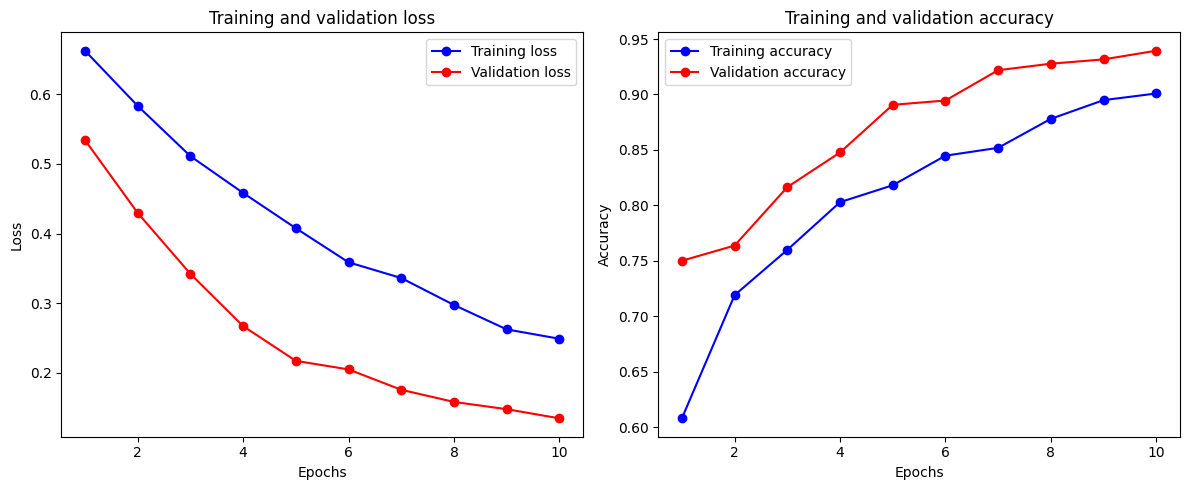

In [ ]:
# Visualization of loss and accuracy
epochs = range(1, epoch_num + 1, val_interval)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch_num + 1), epoch_loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_num + 1), epoch_acc_values, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


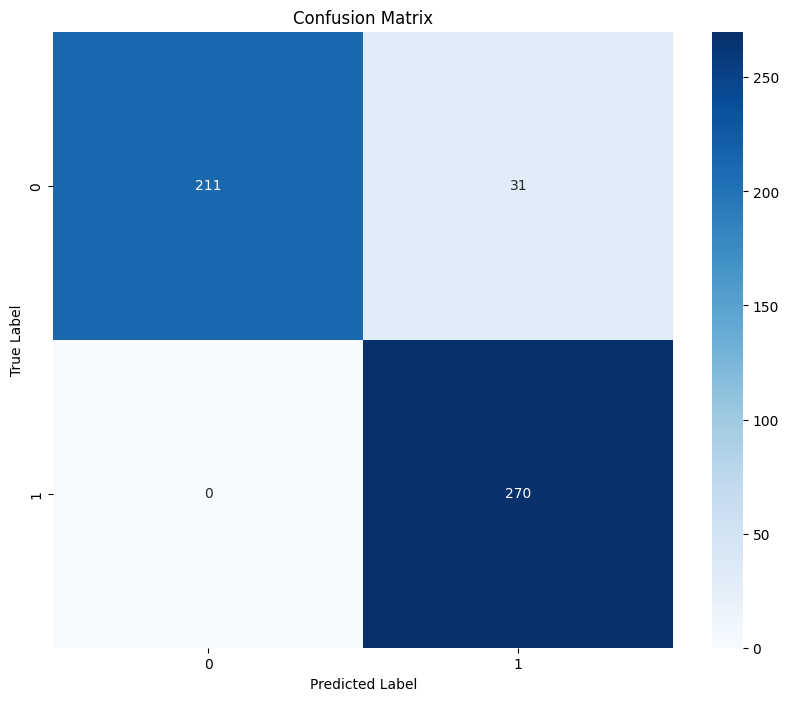

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate confusion matrix at the end
y_true = []
y_pred = []
model_efficientnet.eval()
with torch.no_grad():
    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        outputs = model_efficientnet(val_images)
        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **9.5 K-Neariest Neibours**

In [ ]:
# Feature extraction by flattening the images
def extract_flattened_features(loader):
    features, labels = [], []
    for data in loader:
        inputs, lbls = data
        inputs = inputs.view(inputs.size(0), -1)  # Flatten the images
        features.append(inputs.numpy())
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)


9.5.1  Feature Extraction by Flattening Images for Classifier Input

In [ ]:
train_features, train_labels = extract_flattened_features(train_loader)
val_features, val_labels = extract_flattened_features(val_loader)

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


9.5.2  Training and Predicting with KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features, train_labels)
knn_val_pred = knn.predict(val_features)

9.5.3  Evaluating KNN performace

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate classification report
knn_val_class_report = classification_report(val_labels, knn_val_pred)
print("KNN Validation Classification Report:")
print(knn_val_class_report)

# Generate confusion matrix
knn_val_conf_matrix = confusion_matrix(val_labels, knn_val_pred)

# Print the confusion matrix
print("KNN Validation Confusion Matrix:")
print(knn_val_conf_matrix)

KNN Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78       242
           1       0.76      0.97      0.85       270

    accuracy                           0.82       512
   macro avg       0.86      0.82      0.82       512
weighted avg       0.85      0.82      0.82       512

KNN Validation Confusion Matrix:
[[159  83]
 [  7 263]]


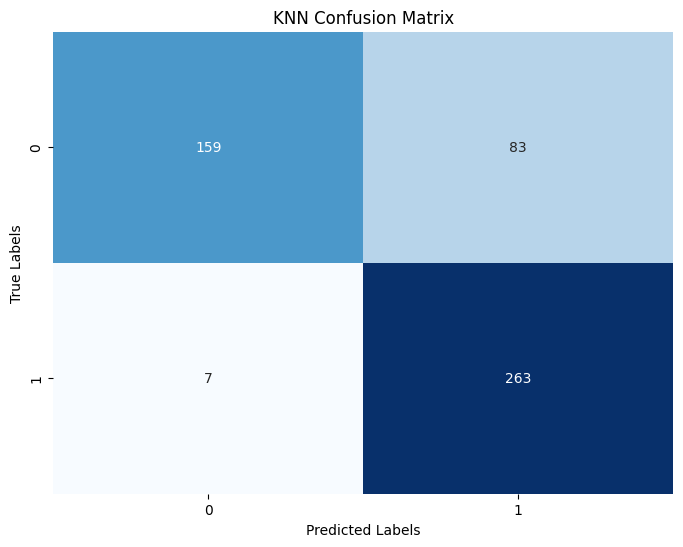

In [ ]:
# Plotting the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(knn_val_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### **9.6  Random Forest Classifier**

9.6.1  Training and Predicting with Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_features, train_labels)
rf_val_pred = rf.predict(val_features)

6.6.2  Evaluating RF Performance

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate classification report
rf_val_class_report = classification_report(val_labels, rf_val_pred)
print("Random Forest Validation Classification Report:")
print(rf_val_class_report)

# Generate confusion matrix
rf_val_conf_matrix = confusion_matrix(val_labels, rf_val_pred)

# Print the confusion matrix
print("Random Forest Validation Confusion Matrix:")
print(rf_val_conf_matrix)

Random Forest Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       242
           1       0.90      0.99      0.94       270

    accuracy                           0.93       512
   macro avg       0.94      0.93      0.93       512
weighted avg       0.94      0.93      0.93       512

Random Forest Validation Confusion Matrix:
[[211  31]
 [  3 267]]


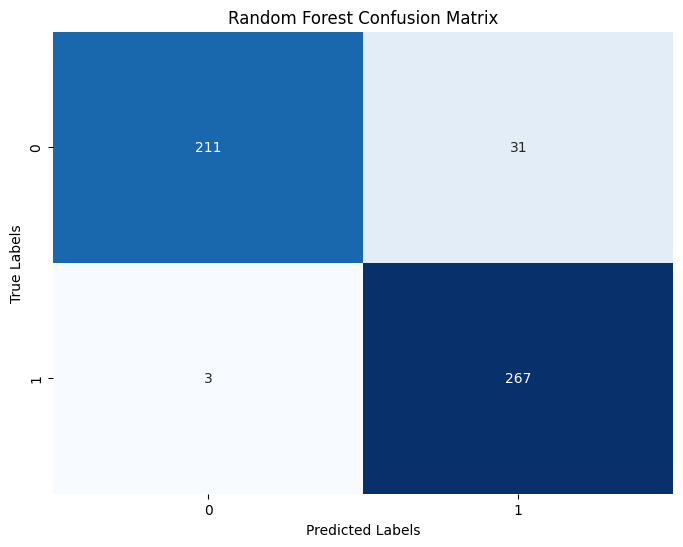

In [ ]:
# Plotting the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(rf_val_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### **9.7 Hybrid Model (VGG16 & ResNet)**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()
        # Load pre-trained VGG16 and ResNet50 models
        self.vgg16 = models.vgg16(pretrained=True)
        self.resnet50 = models.resnet50(pretrained=True)

        # Remove the final classification layer to use features instead
        self.vgg16.classifier = nn.Sequential(*list(self.vgg16.classifier.children())[:-1])
        self.resnet50.fc = nn.Identity()  # Remove the final fully connected layer

        # Define a new classifier for the combined features
        self.classifier = nn.Sequential(
            nn.Linear(4096 + 2048, 512),  # Adjust the input size based on VGG16 and ResNet50 outputs
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vgg_features = self.vgg16(x)
        resnet_features = self.resnet50(x)

        # Concatenate features from both models
        combined_features = torch.cat((vgg_features, resnet_features), dim=1)
        out = self.classifier(combined_features)
        return out

In [ ]:
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, RandRotate, RandFlip, RandZoom, ToTensor

# Define the MONAI transforms for preprocessing the images
train_transforms = Compose([
    LoadImage(image_only=True),  # Load image (assuming file path input)
    EnsureChannelFirst(),  # Ensure channel dimension is first
    ScaleIntensity(),  # Scale pixel values
    RandRotate(range_x=15, prob=0.5, keep_size=True),  # Random rotation
    RandFlip(spatial_axis=0, prob=0.5),  # Random flip
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),  # Random zoom
    ToTensor()  # Convert to tensor
])

val_transforms = Compose([
    LoadImage(image_only=True),  # Load image (assuming file path input)
    EnsureChannelFirst(),  # Ensure channel dimension is first
    ScaleIntensity(),  # Scale pixel values
    ToTensor()  # Convert to tensor
])


In [ ]:
from monai.transforms import LoadImage, EnsureChannelFirst, ScaleIntensity, ToTensor
from torch.utils.data import Dataset

class FundusDataset(Dataset):
    def __init__(self, image_files, labels, transforms=None):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # Load image file path
        image = self.image_files[index]
        label = self.labels[index]

        # Apply transformations
        if self.transforms:
            image = self.transforms(image)

        return image, label


In [ ]:
from torch.utils.data import DataLoader

train_ds = FundusDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=2)

val_ds = FundusDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=10, num_workers=2)

test_ds = FundusDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=10, num_workers=2)

In [ ]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = 2

# Initialize the hybrid model
model = HybridModel(num_classes=num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
epoch_num = 10
val_interval = 1

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


9.7.3 Training Loop for Hybrid Model

In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

best_auc = -1
best_accuracy = -1
best_auc_epoch = -1
best_accuracy_epoch = -1
epoch_loss_values = []
epoch_acc_values = []
val_loss_values = []
metric_values = []
val_acc_values = []
precision_values = []
recall_values = []
f1_values = []

# Path to save the model on Google Drive
save_path = '/content/drive/MyDrive/Dry AMD/Model metrics/final_hybrid_model.pth'

# Loop over epochs
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"Epoch {epoch + 1}/{epoch_num}")

    # Training phase
    model.train()
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        epoch_correct += (predicted == labels).sum().item()
        epoch_total += labels.size(0)

        print(f"{step}/{len(train_loader)}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_accuracy = epoch_correct / epoch_total
    epoch_loss_values.append(epoch_loss)
    epoch_acc_values.append(epoch_accuracy)
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}, average accuracy: {epoch_accuracy:.4f}")

    # Validation phase
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        val_steps = 0
        y_pred_list = []
        y_list = []

        with torch.no_grad():
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                outputs = model(val_images)
                val_loss += loss_function(outputs, val_labels).item()
                val_steps += 1
                y_pred_list.append(outputs.cpu())
                y_list.append(val_labels.cpu())

            val_loss /= val_steps
            val_loss_values.append(val_loss)

            y_pred = torch.cat(y_pred_list, dim=0).numpy()
            y = torch.cat(y_list, dim=0).numpy()

            # Convert labels to one-hot encoding
            y_onehot = torch.nn.functional.one_hot(torch.tensor(y), num_classes=num_classes).numpy()

            # Compute AUC
            auc_result = roc_auc_score(y_onehot, y_pred, multi_class='ovr')
            metric_values.append(auc_result)

            # Calculate precision, recall, and F1-score
            y_pred_classes = torch.tensor(y_pred).argmax(dim=1).numpy()
            precision = precision_score(y, y_pred_classes, average='weighted')
            recall = recall_score(y, y_pred_classes, average='weighted')
            f1 = f1_score(y, y_pred_classes, average='weighted')

            precision_values.append(precision)
            recall_values.append(recall)
            f1_values.append(f1)

            acc_value = torch.eq(torch.tensor(y_pred).argmax(dim=1), torch.tensor(y))
            acc_metric = acc_value.sum().item() / len(acc_value)
            val_acc_values.append(acc_metric)

            if auc_result > best_auc:
                best_auc = auc_result
                best_auc_epoch = epoch + 1
            if acc_metric > best_accuracy:
                best_accuracy = acc_metric
                best_accuracy_epoch = epoch + 1
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'best_auc': best_auc,
                    'best_auc_epoch': best_auc_epoch,
                    'best_accuracy': best_accuracy,
                    'best_accuracy_epoch': best_accuracy_epoch,
                    'best_precision': precision,
                    'best_recall': recall,
                    'best_f1': f1,
                }, save_path)
                print('Saved new best metric model')

            print(f"Current epoch: {epoch + 1} current AUC: {auc_result:.4f}, current accuracy: {acc_metric:.4f}")
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
            print(f"Best AUC: {best_auc:.4f} at epoch: {best_auc_epoch}, Best accuracy: {best_accuracy:.4f} at epoch: {best_accuracy_epoch}")
            print(f"Validation loss: {val_loss:.4f}")

print(f"Training completed, best AUC: {best_auc:.4f} at epoch: {best_auc_epoch}, best accuracy: {best_accuracy:.4f} at epoch: {best_accuracy_epoch}")


----------
Epoch 1/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/184, train_loss: 0.6409
2/184, train_loss: 0.6227
3/184, train_loss: 0.7572
4/184, train_loss: 0.6742
5/184, train_loss: 0.8044
6/184, train_loss: 0.7120
7/184, train_loss: 0.6857
8/184, train_loss: 0.7371
9/184, train_loss: 0.7184
10/184, train_loss: 0.7117
11/184, train_loss: 0.7040
12/184, train_loss: 0.7329
13/184, train_loss: 0.6517
14/184, train_loss: 0.6997
15/184, train_loss: 0.6345
16/184, train_loss: 0.7262
17/184, train_loss: 0.7089
18/184, train_loss: 0.6285
19/184, train_loss: 0.6782
20/184, train_loss: 0.7254
21/184, train_loss: 0.7034
22/184, train_loss: 0.7527
23/184, train_loss: 0.6249
24/184, train_loss: 0.6573
25/184, train_loss: 0.7647
26/184, train_loss: 0.6643
27/184, train_loss: 0.6161
28/184, train_loss: 0.7039
29/184, train_loss: 0.6540
30/184, train_loss: 0.7146
31/184, train_loss: 0.7066
32/184, train_loss: 0.6053
33/184, train_loss: 0.6798
34/184, train_loss: 0.5966
35/184, train_loss: 0.6509
36/184, train_loss: 0.7132
37/184, train_loss: 0.6809
38/184, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/184, train_loss: 0.3313
2/184, train_loss: 0.2182
3/184, train_loss: 0.3769
4/184, train_loss: 0.1297
5/184, train_loss: 0.1456
6/184, train_loss: 0.1242
7/184, train_loss: 0.1884
8/184, train_loss: 0.2359
9/184, train_loss: 0.2405
10/184, train_loss: 0.2501
11/184, train_loss: 0.2197
12/184, train_loss: 0.0816
13/184, train_loss: 0.3268
14/184, train_loss: 0.3132
15/184, train_loss: 0.5406
16/184, train_loss: 0.2688
17/184, train_loss: 0.3508
18/184, train_loss: 0.3967
19/184, train_loss: 0.1476
20/184, train_loss: 0.3771
21/184, train_loss: 0.1103
22/184, train_loss: 0.2598
23/184, train_loss: 0.4462
24/184, train_loss: 0.7592
25/184, train_loss: 0.1835
26/184, train_loss: 0.6573
27/184, train_loss: 0.5619
28/184, train_loss: 0.4083
29/184, train_loss: 0.2994
30/184, train_loss: 0.4888
31/184, train_loss: 0.5173
32/184, train_loss: 0.1931
33/184, train_loss: 0.2010
34/184, train_loss: 0.2038
35/184, train_loss: 0.2169
36/184, train_loss: 0.1202
37/184, train_loss: 0.1512
38/184, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/184, train_loss: 0.0192
2/184, train_loss: 0.0793
3/184, train_loss: 0.0163
4/184, train_loss: 0.1667
5/184, train_loss: 0.0667
6/184, train_loss: 0.0611
7/184, train_loss: 0.0778
8/184, train_loss: 0.0768
9/184, train_loss: 0.0102
10/184, train_loss: 0.1875
11/184, train_loss: 0.0150
12/184, train_loss: 0.0222
13/184, train_loss: 0.0192
14/184, train_loss: 0.0911
15/184, train_loss: 0.0453
16/184, train_loss: 0.0390
17/184, train_loss: 0.0238
18/184, train_loss: 0.2658
19/184, train_loss: 0.3255
20/184, train_loss: 0.1065
21/184, train_loss: 0.0153
22/184, train_loss: 0.2212
23/184, train_loss: 0.0413
24/184, train_loss: 0.0833
25/184, train_loss: 0.2313
26/184, train_loss: 0.1657
27/184, train_loss: 0.5266
28/184, train_loss: 0.0972
29/184, train_loss: 0.0365
30/184, train_loss: 0.1265
31/184, train_loss: 0.0541
32/184, train_loss: 0.0770
33/184, train_loss: 0.0203
34/184, train_loss: 0.0225
35/184, train_loss: 0.0440
36/184, train_loss: 0.4906
37/184, train_loss: 0.0494
38/184, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/184, train_loss: 0.3195
2/184, train_loss: 0.0040
3/184, train_loss: 0.0152
4/184, train_loss: 0.0088
5/184, train_loss: 0.1150
6/184, train_loss: 0.1388
7/184, train_loss: 0.0509
8/184, train_loss: 0.0112
9/184, train_loss: 0.0150
10/184, train_loss: 0.0201
11/184, train_loss: 0.0214
12/184, train_loss: 0.0107
13/184, train_loss: 0.0164
14/184, train_loss: 0.0096
15/184, train_loss: 0.0203
16/184, train_loss: 0.1436
17/184, train_loss: 0.0071
18/184, train_loss: 0.0241
19/184, train_loss: 0.0953
20/184, train_loss: 0.0402
21/184, train_loss: 0.0784
22/184, train_loss: 0.0188
23/184, train_loss: 0.1677
24/184, train_loss: 0.2183
25/184, train_loss: 0.0959
26/184, train_loss: 0.0301
27/184, train_loss: 0.0057
28/184, train_loss: 0.0087
29/184, train_loss: 0.0455
30/184, train_loss: 0.0525
31/184, train_loss: 0.0805
32/184, train_loss: 0.0335
33/184, train_loss: 0.0178
34/184, train_loss: 0.0838
35/184, train_loss: 0.2047
36/184, train_loss: 0.1364
37/184, train_loss: 0.1543
38/184, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/184, train_loss: 0.0018
2/184, train_loss: 0.0129
3/184, train_loss: 0.0031
4/184, train_loss: 0.0438
5/184, train_loss: 0.1848
6/184, train_loss: 0.0168
7/184, train_loss: 0.0147
8/184, train_loss: 0.1618
9/184, train_loss: 0.0046
10/184, train_loss: 0.0101
11/184, train_loss: 0.0212
12/184, train_loss: 0.0015
13/184, train_loss: 0.2499
14/184, train_loss: 0.0272
15/184, train_loss: 0.0062
16/184, train_loss: 0.0470
17/184, train_loss: 0.0055
18/184, train_loss: 0.1495
19/184, train_loss: 0.1041
20/184, train_loss: 0.0136
21/184, train_loss: 0.0076
22/184, train_loss: 0.0699
23/184, train_loss: 0.0980
24/184, train_loss: 0.0040
25/184, train_loss: 0.0362
26/184, train_loss: 0.0085
27/184, train_loss: 0.0717
28/184, train_loss: 0.0151
29/184, train_loss: 0.0321
30/184, train_loss: 0.0030
31/184, train_loss: 0.1982
32/184, train_loss: 0.0553
33/184, train_loss: 0.2025
34/184, train_loss: 0.0302
35/184, train_loss: 0.0056
36/184, train_loss: 0.0967
37/184, train_loss: 0.1168
38/184, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


184/184, train_loss: 0.0057
Epoch 5 average loss: 0.0527, average accuracy: 0.9798
Current epoch: 5 current AUC: 1.0000, current accuracy: 0.9863
Precision: 0.9867, Recall: 0.9863, F1-Score: 0.9863
Best AUC: 1.0000 at epoch: 5, Best accuracy: 0.9941 at epoch: 3
Validation loss: 0.0354
----------
Epoch 6/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/184, train_loss: 0.0008
2/184, train_loss: 0.0040
3/184, train_loss: 0.1184
4/184, train_loss: 0.1578
5/184, train_loss: 0.0047
6/184, train_loss: 0.0647
7/184, train_loss: 0.0921
8/184, train_loss: 0.2010
9/184, train_loss: 0.1961
10/184, train_loss: 0.0207
11/184, train_loss: 0.0035
12/184, train_loss: 0.0898
13/184, train_loss: 0.1022
14/184, train_loss: 0.0026
15/184, train_loss: 0.0273
16/184, train_loss: 0.0328
17/184, train_loss: 0.0946
18/184, train_loss: 0.0278
19/184, train_loss: 0.0283
20/184, train_loss: 0.0858
21/184, train_loss: 0.2475
22/184, train_loss: 0.0176
23/184, train_loss: 0.2184
24/184, train_loss: 0.8825
25/184, train_loss: 0.0419
26/184, train_loss: 0.1338
27/184, train_loss: 0.0193
28/184, train_loss: 0.1182
29/184, train_loss: 0.0123
30/184, train_loss: 0.0419
31/184, train_loss: 0.0108
32/184, train_loss: 0.0059
33/184, train_loss: 0.1260
34/184, train_loss: 0.0128
35/184, train_loss: 0.1390
36/184, train_loss: 0.0604
37/184, train_loss: 0.1013
38/184, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


184/184, train_loss: 0.0138
Epoch 6 average loss: 0.0479, average accuracy: 0.9788
Saved new best metric model
Current epoch: 6 current AUC: 1.0000, current accuracy: 0.9961
Precision: 0.9961, Recall: 0.9961, F1-Score: 0.9961
Best AUC: 1.0000 at epoch: 6, Best accuracy: 0.9961 at epoch: 6
Validation loss: 0.0138
----------
Epoch 7/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/184, train_loss: 0.0042
2/184, train_loss: 0.0108
3/184, train_loss: 0.0054
4/184, train_loss: 0.0178
5/184, train_loss: 0.0049
6/184, train_loss: 0.4247
7/184, train_loss: 0.0041
8/184, train_loss: 0.0188
9/184, train_loss: 0.0138
10/184, train_loss: 0.0365
11/184, train_loss: 0.0017
12/184, train_loss: 0.0029
13/184, train_loss: 0.0789
14/184, train_loss: 0.1524
15/184, train_loss: 0.0067
16/184, train_loss: 0.0770
17/184, train_loss: 0.0096
18/184, train_loss: 0.0076
19/184, train_loss: 0.0938
20/184, train_loss: 0.0326
21/184, train_loss: 0.0052
22/184, train_loss: 0.0609
23/184, train_loss: 0.0042
24/184, train_loss: 0.0047
25/184, train_loss: 0.1659
26/184, train_loss: 0.3996
27/184, train_loss: 0.0330
28/184, train_loss: 0.0077
29/184, train_loss: 0.0070
30/184, train_loss: 0.0031
31/184, train_loss: 0.0516
32/184, train_loss: 0.0728
33/184, train_loss: 0.0211
34/184, train_loss: 0.0235
35/184, train_loss: 0.0027
36/184, train_loss: 0.0124
37/184, train_loss: 0.0141
38/184, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/184, train_loss: 0.0067
2/184, train_loss: 0.0008
3/184, train_loss: 0.0046
4/184, train_loss: 0.0129
5/184, train_loss: 0.0172
6/184, train_loss: 0.0029
7/184, train_loss: 0.0101
8/184, train_loss: 0.0014
9/184, train_loss: 0.0072
10/184, train_loss: 0.1543
11/184, train_loss: 0.0088
12/184, train_loss: 0.0005
13/184, train_loss: 0.0037
14/184, train_loss: 0.0037
15/184, train_loss: 0.1656
16/184, train_loss: 0.0450
17/184, train_loss: 0.0495
18/184, train_loss: 0.0047
19/184, train_loss: 0.1333
20/184, train_loss: 0.0044
21/184, train_loss: 0.0198
22/184, train_loss: 0.0055
23/184, train_loss: 0.0051
24/184, train_loss: 0.0121
25/184, train_loss: 0.0001
26/184, train_loss: 0.0019
27/184, train_loss: 0.0039
28/184, train_loss: 0.0014
29/184, train_loss: 0.0149
30/184, train_loss: 0.0356
31/184, train_loss: 0.0080
32/184, train_loss: 0.0740
33/184, train_loss: 0.0050
34/184, train_loss: 0.0016
35/184, train_loss: 0.0010
36/184, train_loss: 0.0009
37/184, train_loss: 0.0008
38/184, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


184/184, train_loss: 0.0029
Epoch 8 average loss: 0.0228, average accuracy: 0.9929
Current epoch: 8 current AUC: 0.9999, current accuracy: 0.9980
Precision: 0.9981, Recall: 0.9980, F1-Score: 0.9980
Best AUC: 1.0000 at epoch: 6, Best accuracy: 0.9980 at epoch: 7
Validation loss: 0.0115
----------
Epoch 9/10


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/184, train_loss: 0.0011
2/184, train_loss: 0.0017
3/184, train_loss: 0.0009
4/184, train_loss: 0.0028
5/184, train_loss: 0.0008
6/184, train_loss: 0.0058
7/184, train_loss: 0.0096
8/184, train_loss: 0.0003
9/184, train_loss: 0.0010
10/184, train_loss: 0.0018
11/184, train_loss: 0.0373
12/184, train_loss: 0.1069
13/184, train_loss: 0.2477
14/184, train_loss: 0.0153
15/184, train_loss: 0.0006
16/184, train_loss: 0.0159
17/184, train_loss: 0.0854
18/184, train_loss: 0.0005
19/184, train_loss: 0.0008
20/184, train_loss: 0.0009
21/184, train_loss: 0.0040
22/184, train_loss: 0.0024
23/184, train_loss: 0.1161
24/184, train_loss: 0.0056
25/184, train_loss: 0.0128
26/184, train_loss: 0.3780
27/184, train_loss: 0.0053
28/184, train_loss: 0.0019
29/184, train_loss: 0.0103
30/184, train_loss: 0.0038
31/184, train_loss: 0.0230
32/184, train_loss: 0.0157
33/184, train_loss: 0.0013
34/184, train_loss: 0.0035
35/184, train_loss: 0.0041
36/184, train_loss: 0.0008
37/184, train_loss: 0.0122
38/184, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1/184, train_loss: 0.0055
2/184, train_loss: 0.0084
3/184, train_loss: 0.0030
4/184, train_loss: 0.0865
5/184, train_loss: 0.0014
6/184, train_loss: 0.0024
7/184, train_loss: 0.3270
8/184, train_loss: 0.0069
9/184, train_loss: 0.0034
10/184, train_loss: 0.0097
11/184, train_loss: 0.0132
12/184, train_loss: 0.0262
13/184, train_loss: 0.0133
14/184, train_loss: 0.0109
15/184, train_loss: 0.0055
16/184, train_loss: 0.0013
17/184, train_loss: 0.0562
18/184, train_loss: 0.0055
19/184, train_loss: 0.0263
20/184, train_loss: 0.0199
21/184, train_loss: 0.0387
22/184, train_loss: 0.0131
23/184, train_loss: 0.0171
24/184, train_loss: 0.0014
25/184, train_loss: 0.0009
26/184, train_loss: 0.0144
27/184, train_loss: 0.0056
28/184, train_loss: 0.0020
29/184, train_loss: 0.0211
30/184, train_loss: 0.0017
31/184, train_loss: 0.0270
32/184, train_loss: 0.0105
33/184, train_loss: 0.0141
34/184, train_loss: 0.0117
35/184, train_loss: 0.0026
36/184, train_loss: 0.0056
37/184, train_loss: 0.0058
38/184, tr

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


184/184, train_loss: 0.0137
Epoch 10 average loss: 0.0160, average accuracy: 0.9962
Current epoch: 10 current AUC: 1.0000, current accuracy: 0.9980
Precision: 0.9981, Recall: 0.9980, F1-Score: 0.9980
Best AUC: 1.0000 at epoch: 6, Best accuracy: 0.9980 at epoch: 7
Validation loss: 0.0029
Training completed, best AUC: 1.0000 at epoch: 6, best accuracy: 0.9980 at epoch: 7


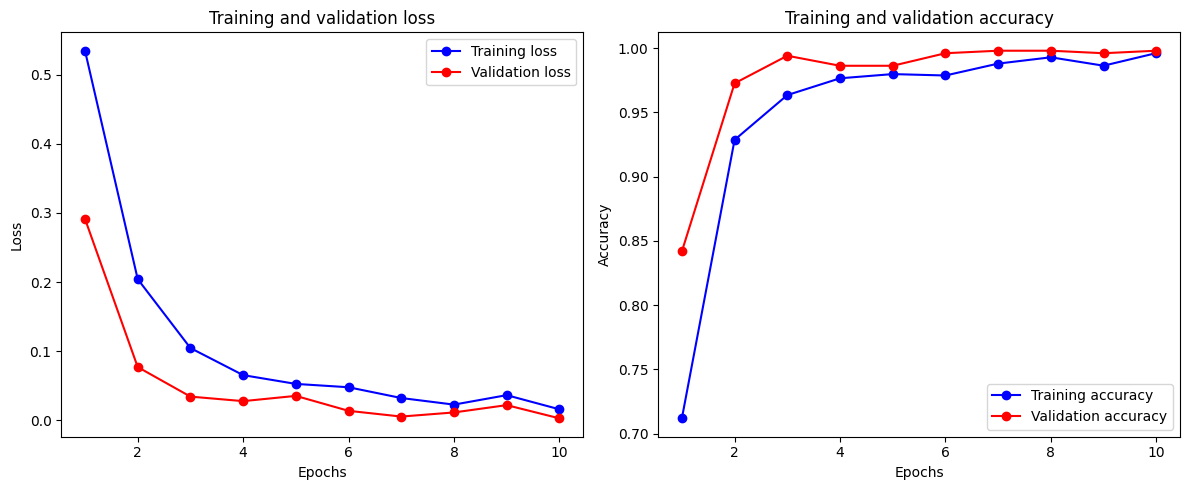

In [ ]:
# Visualization of loss and accuracy
epochs = range(1, epoch_num + 1, val_interval)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch_num + 1), epoch_loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_num + 1), epoch_acc_values, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


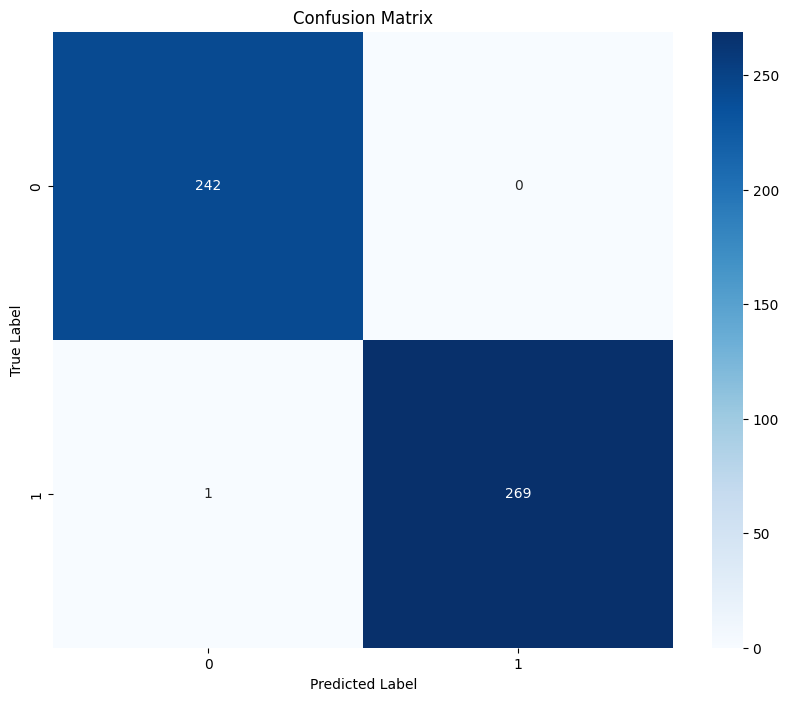

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate confusion matrix at the end
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        outputs = model(val_images)
        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import densenet121, vgg16, resnet50
from torchvision.models.efficientnet import efficientnet_b0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = 2  # Update this with the actual number of classes

# Adjust DenseNet for grayscale input
densenet_model = densenet121(pretrained=False, num_classes=num_classes)
densenet_model.features.conv0 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
densenet_model = densenet_model.to(device)

# Load DenseNet checkpoint
densenet_load_path = '/content/drive/MyDrive/Dry AMD/Model metrics/best_dense_metric_model.pth'
densenet_checkpoint = torch.load(densenet_load_path, map_location=device)
densenet_model.load_state_dict(densenet_checkpoint['model_state_dict'], strict=False)

# Adjust VGG16 for grayscale input
vgg16_model = vgg16(pretrained=False, num_classes=num_classes)
vgg16_model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg16_model = vgg16_model.to(device)

# Load VGG16 checkpoint
vgg16_load_path = '/content/drive/MyDrive/Dry AMD/Model metrics/vgg_best_metric_model.pth'
vgg16_checkpoint = torch.load(vgg16_load_path, map_location=device)
vgg16_model.load_state_dict(vgg16_checkpoint['model_state_dict'], strict=False)

# Adjust ResNet for grayscale input
resnet_model = resnet50(pretrained=False, num_classes=num_classes)
resnet_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

# Load ResNet checkpoint
resnet_load_path = '/content/drive/MyDrive/Dry AMD/Model metrics/resnet_best_metric_model.pth'
resnet_checkpoint = torch.load(resnet_load_path, map_location=device)
resnet_model.load_state_dict(resnet_checkpoint['model_state_dict'], strict=False)

# Adjust EfficientNet for grayscale input
efficientnet_model = efficientnet_b0(pretrained=False, num_classes=num_classes)
efficientnet_model.features[0][0] = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
efficientnet_model = efficientnet_model.to(device)

# Load EfficientNet checkpoint
efficientnet_load_path = '/content/drive/MyDrive/Dry AMD/Model metrics/efficientnet_best_metric_model.pth'
efficientnet_checkpoint = torch.load(efficientnet_load_path, map_location=device)
efficientnet_model.load_state_dict(efficientnet_checkpoint['model_state_dict'], strict=False)

# Load Hybrid Model
class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()
        # Load pre-trained VGG16 and ResNet50 models
        self.vgg16 = models.vgg16(pretrained=True)
        self.resnet50 = models.resnet50(pretrained=True)

        # Remove the final classification layer to use features instead
        self.vgg16.classifier = nn.Sequential(*list(self.vgg16.classifier.children())[:-1])
        self.resnet50.fc = nn.Identity()  # Remove the final fully connected layer

        # Define a new classifier for the combined features
        self.classifier = nn.Sequential(
            nn.Linear(4096 + 2048, 512),  # Adjust the input size based on VGG16 and ResNet50 outputs
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vgg_features = self.vgg16(x)
        resnet_features = self.resnet50(x)

        # Concatenate features from both models
        combined_features = torch.cat((vgg_features, resnet_features), dim=1)
        out = self.classifier(combined_features)
        return out

hybrid_model = HybridModel(num_classes=num_classes).to(device)

# Load Hybrid Model checkpoint
hybrid_load_path = '/content/drive/MyDrive/Dry AMD/Model metrics/final_hybrid_model.pth'
hybrid_checkpoint = torch.load(hybrid_load_path, map_location=device)
hybrid_model.load_state_dict(hybrid_checkpoint['model_state_dict'], strict=False)

# Extract the saved best metrics for each model
densenet_best_accuracy = densenet_checkpoint['dense_best_metric']
densenet_best_precision = densenet_checkpoint['best_precision']
densenet_best_recall = densenet_checkpoint['best_recall']
densenet_best_f1 = densenet_checkpoint['best_f1']

vgg16_best_accuracy = vgg16_checkpoint['vgg_best_accuracy']
vgg16_best_precision = vgg16_checkpoint['best_precision']
vgg16_best_recall = vgg16_checkpoint['best_recall']
vgg16_best_f1 = vgg16_checkpoint['best_f1']

resnet_best_accuracy = resnet_checkpoint['resnet_best_accuracy']
resnet_best_precision = resnet_checkpoint['best_precision']
resnet_best_recall = resnet_checkpoint['best_recall']
resnet_best_f1 = resnet_checkpoint['best_f1']

efficientnet_best_accuracy = efficientnet_checkpoint['efficientnet_best_accuracy']
efficientnet_best_precision = efficientnet_checkpoint['best_precision']
efficientnet_best_recall = efficientnet_checkpoint['best_recall']
efficientnet_best_f1 = efficientnet_checkpoint['best_f1']

hybrid_best_accuracy = hybrid_checkpoint['best_accuracy']
hybrid_best_precision = hybrid_checkpoint['best_precision']
hybrid_best_recall = hybrid_checkpoint['best_recall']
hybrid_best_f1 = hybrid_checkpoint['best_f1']


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


In [ ]:
# Print out the best metrics for each model
print(f"Best DenseNet accuracy: {densenet_best_accuracy}, precision: {densenet_best_precision}, recall: {densenet_best_recall}, F1-score: {densenet_best_f1}")
print(f"Best VGG16 accuracy: {vgg16_best_accuracy}, precision: {vgg16_best_precision}, recall: {vgg16_best_recall}, F1-score: {vgg16_best_f1}")
print(f"Best ResNet accuracy: {resnet_best_accuracy}, precision: {resnet_best_precision}, recall: {resnet_best_recall}, F1-score: {resnet_best_f1}")
print(f"Best EfficientNet accuracy: {efficientnet_best_accuracy}, precision: {efficientnet_best_precision}, recall: {efficientnet_best_recall}, F1-score: {efficientnet_best_f1}")
print(f"Best Hybrid Model accuracy: {hybrid_best_accuracy}, precision: {hybrid_best_precision}, recall: {hybrid_best_recall}, F1-score: {hybrid_best_f1}")


Best DenseNet accuracy: 0.91015625, precision: 0.9102670758106116, recall: 0.91015625, F1-score: 0.9100860240700721
Best VGG16 accuracy: 0.974609375, precision: 0.9754338512540248, recall: 0.974609375, F1-score: 0.9745675806145275
Best ResNet accuracy: 0.986328125, precision: 0.9864999880130418, recall: 0.986328125, F1-score: 0.9863194836815996
Best EfficientNet accuracy: 0.939453125, precision: 0.945688849667774, recall: 0.939453125, F1-score: 0.9390249994684204
Best Hybrid Model accuracy: 0.998046875, precision: 0.9980549125514404, recall: 0.998046875, F1-score: 0.9980470767266607


### **9.10 Comparison of accuracies of all Implemented Models**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for each model
metrics = {
    "VGG + ResNet": hybrid_best_accuracy,
    "ResNet50": resnet_best_accuracy,
    "VGG16": vgg16_best_accuracy,
    'Random Forest':0.9405,
    "EfficientNet": efficientnet_best_accuracy,
    "DenseNet121": densenet_best_accuracy,
    "KNN": 0.8115,
}

# Extract the model names and their best accuracies
models = list(metrics.keys())
best_accuracies = list(metrics.values())


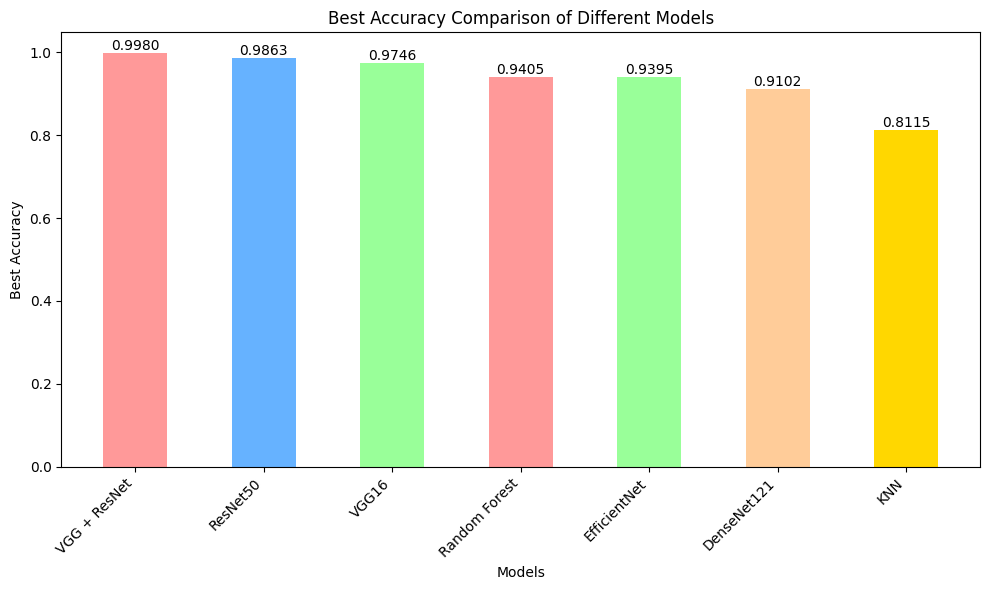

In [ ]:
import matplotlib.pyplot as plt

# Define the position of bars on X-axis
x = np.arange(len(models))

# Set the width of the bars
width = 0.5

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, best_accuracies, width, color=['#FF9999', '#66B2FF', '#99FF99','#FF9999','#99FF99', '#FFCC99', '#FFD700'])

# Add labels, title, and custom X-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Best Accuracy')
ax.set_title('Best Accuracy Comparison of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height,
            f'{height:.4f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


# **Prediction Using Hybrid Model**

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `hybrid_model` is already defined and loaded with the pretrained weights
hybrid_model.eval()

# Initialize lists to store data
images, predictions, actuals, confidences = [], [], [], []

class_counter = {}
num_classes = len(class_names)  # Assuming class_names is defined

# Set a target for how many samples you want from each class
target_samples_per_class = 2

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)

        outputs = hybrid_model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        # Convert to numpy for easier processing
        preds_np = preds.cpu().numpy()
        labels_np = labels.cpu().numpy()
        probs_np = probs.max(dim=1)[0].cpu().numpy()
        inputs_np = inputs.cpu().numpy()

        for i in range(len(preds_np)):
            label = labels_np[i]
            if class_counter.get(label, 0) < target_samples_per_class:
                predictions.append(preds_np[i])
                actuals.append(labels_np[i])
                confidences.append(probs_np[i])
                images.append(inputs_np[i])

                # Increment the class counter
                class_counter[label] = class_counter.get(label, 0) + 1

        # Check if we've collected enough samples from all classes
        if all([class_counter.get(cls, 0) >= target_samples_per_class for cls in range(num_classes)]):
            break

# Convert to numpy arrays for easier handling
y_pred = np.array(predictions)
y_test = np.array(actuals)
confidence_scores = np.array(confidences)
images = np.array(images)

# Create a DataFrame to compare actual vs predicted (optional)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Actual  Prediction
0       0           0
1       0           0
2       1           1
3       1           1

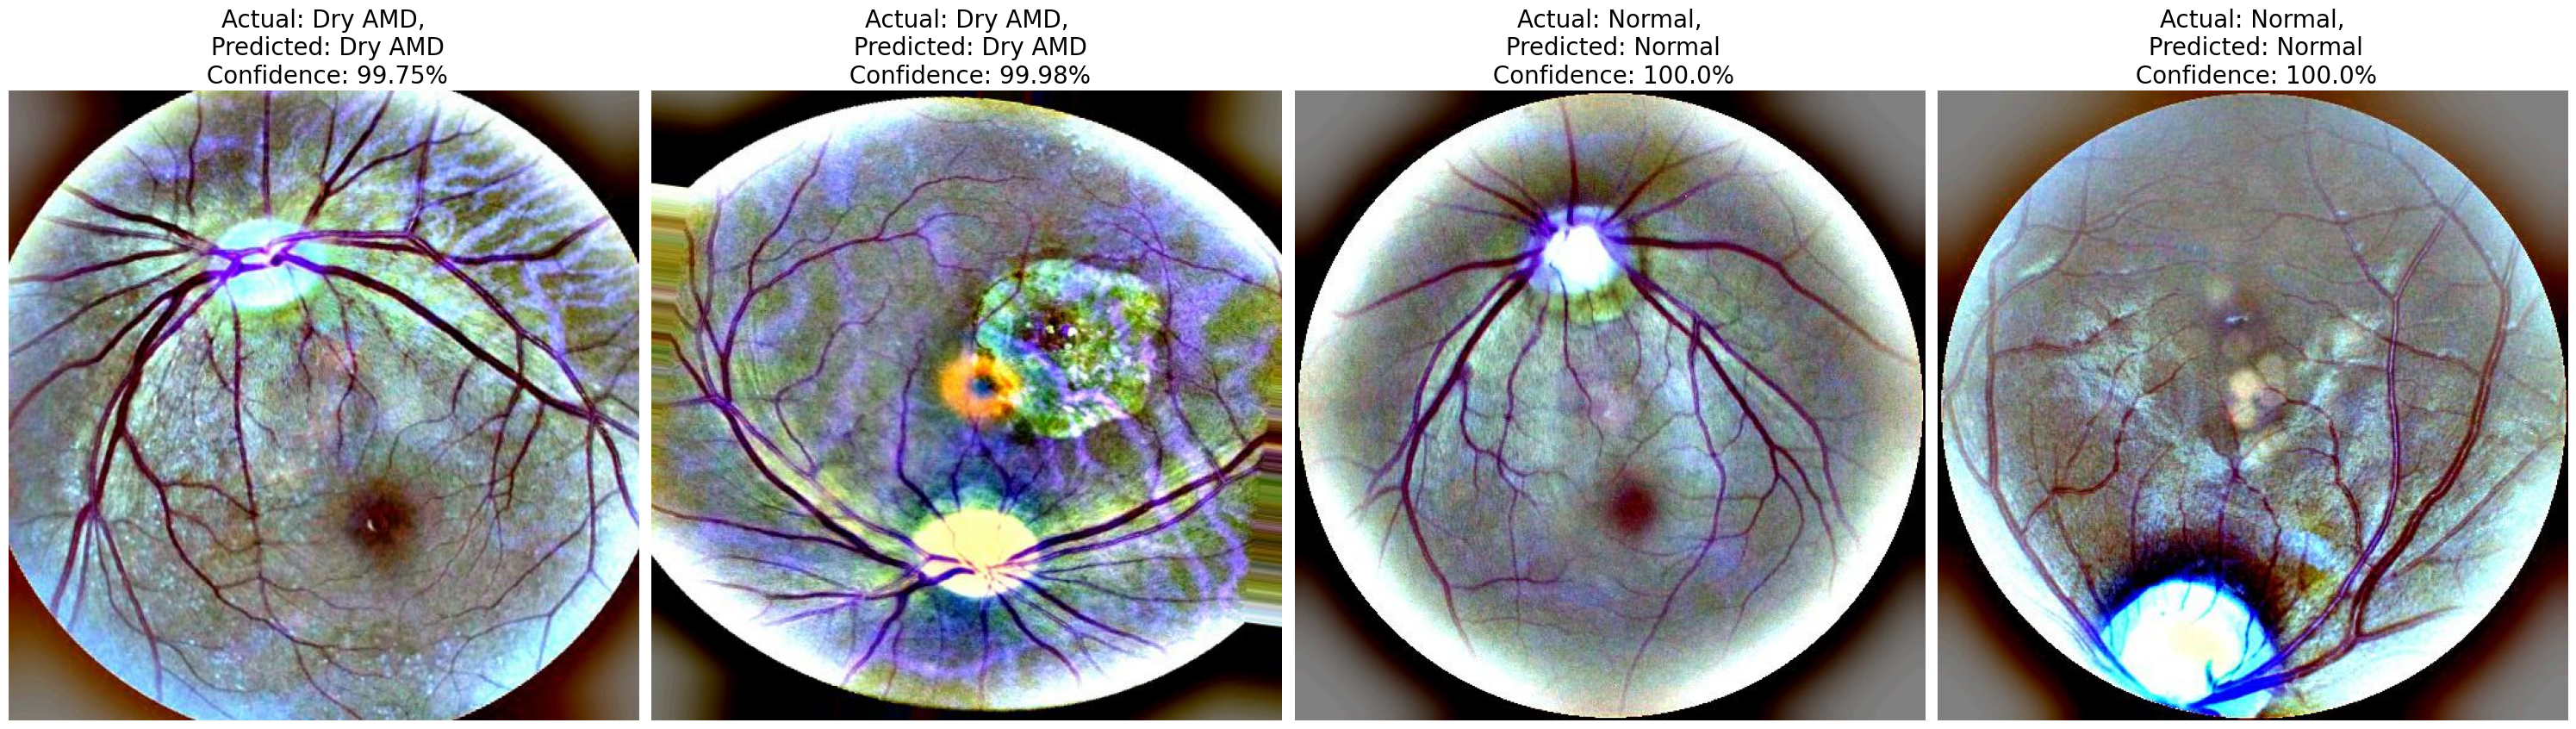

In [ ]:
# Define your class labels (replace with your actual class names)
class_names = ['Dry AMD', 'Normal']  # Modify as per your classes

# Plotting the images with their actual and predicted labels
plt.figure(figsize=(30, 70))

batch_size = len(y_test)  # Get the actual batch size

for n in range(batch_size):  # Visualize all images in the first batch
    plt.subplot(8, 4, n + 1)

    # Assuming images are grayscale (1 channel)
    img = np.squeeze(images[n]) if images.shape[1] == 1 else np.transpose(images[n], (1, 2, 0))

    plt.imshow(img, cmap='gray' if images.shape[1] == 1 else None)
    plt.axis('off')
    actual_class = class_names[y_test[n]]
    predicted_class = class_names[y_pred[n]]
    confidence = round(confidence_scores[n] * 100, 2)  # Confidence as a percentage

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}\n Confidence: {confidence}%", fontsize=20)

plt.tight_layout()
plt.show()
